# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [1]:
import sys
sys.path.insert(0, '../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)
tf.set_random_seed(1234)

## Physics-informed Neural Networks

In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X, u, layers, lb, ub):
        
        self.lb = lb
        self.ub = ub
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        self.u = u
        
        self.layers = layers
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([-6.0], dtype=tf.float32)
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
                
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):  
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
        lambda_2 = tf.exp(self.lambda_2)
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_t + lambda_1*u*u_x - lambda_2*u_xx
        
        return f
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, lambda_1, np.exp(lambda_2)))
        
        
    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = np.exp(self.sess.run(self.lambda_2))
                print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
                start_time = time.time()
        
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.lambda_1, self.lambda_2],
                                loss_callback = self.callback)
        
        
    def predict(self, X_star):
        
        tf_dict = {self.x_tf: X_star[:,0:1], self.t_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        
        return u_star, f_star

## Configurations

In [3]:
nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

## Training on Non-noisy Data

In [4]:
noise = 0.0            

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(0)

# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0)*100
error_lambda_2 = np.abs(lambda_2_value - nu)/nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Loss: 3.949373e-01, l1: 0.00000, l2: 0.00248
Loss: 7.736640e-01, l1: 0.00000, l2: 0.00248
Loss: 3.374787e-01, l1: 0.00000, l2: 0.00248
Loss: 2.880106e-01, l1: 0.00016, l2: 0.00248
Loss: 8.284872e+00, l1: 0.00138, l2: 0.00248
Loss: 2.714846e-01, l1: 0.00022, l2: 0.00248
Loss: 2.565791e-01, l1: 0.00035, l2: 0.00248
Loss: 2.386289e-01, l1: 0.00033, l2: 0.00248
Loss: 2.358943e-01, l1: 0.00035, l2: 0.00248
Loss: 2.344091e-01, l1: 0.00035, l2: 0.00248
Loss: 2.298073e-01, l1: 0.00035, l2: 0.00248
Loss: 2.098750e-01, l1: 0.00028, l2: 0.00248
Loss: 2.486432e-01, l1: -0.00004, l2: 0.00248
Loss: 1.964650e-01, l1: 0.00017, l2: 0.00248
Loss: 1.71698

Loss: 9.569109e-03, l1: 0.52159, l2: 0.00307
Loss: 9.558937e-03, l1: 0.52203, l2: 0.00307
Loss: 9.528305e-03, l1: 0.52399, l2: 0.00308
Loss: 9.450573e-03, l1: 0.52968, l2: 0.00311
Loss: 9.420897e-03, l1: 0.54371, l2: 0.00315
Loss: 9.312545e-03, l1: 0.54840, l2: 0.00318
Loss: 9.266072e-03, l1: 0.54251, l2: 0.00317
Loss: 9.202265e-03, l1: 0.54794, l2: 0.00319
Loss: 9.167606e-03, l1: 0.55382, l2: 0.00322
Loss: 9.146893e-03, l1: 0.55181, l2: 0.00322
Loss: 9.106038e-03, l1: 0.54668, l2: 0.00324
Loss: 9.093274e-03, l1: 0.54288, l2: 0.00327
Loss: 9.060677e-03, l1: 0.54127, l2: 0.00327
Loss: 9.052237e-03, l1: 0.54167, l2: 0.00327
Loss: 9.031564e-03, l1: 0.54163, l2: 0.00328
Loss: 9.002695e-03, l1: 0.54176, l2: 0.00330
Loss: 8.954335e-03, l1: 0.54395, l2: 0.00333
Loss: 8.874427e-03, l1: 0.54773, l2: 0.00337
Loss: 8.766835e-03, l1: 0.55219, l2: 0.00342
Loss: 8.681595e-03, l1: 0.56134, l2: 0.00351
Loss: 8.674536e-03, l1: 0.55805, l2: 0.00349
Loss: 8.605307e-03, l1: 0.56154, l2: 0.00351
Loss: 8.60

Loss: 4.158829e-03, l1: 0.80803, l2: 0.00473
Loss: 4.063825e-03, l1: 0.81065, l2: 0.00473
Loss: 3.963658e-03, l1: 0.80889, l2: 0.00472
Loss: 3.931674e-03, l1: 0.79888, l2: 0.00469
Loss: 3.884483e-03, l1: 0.79831, l2: 0.00471
Loss: 3.874360e-03, l1: 0.80351, l2: 0.00471
Loss: 3.842067e-03, l1: 0.80194, l2: 0.00470
Loss: 3.819742e-03, l1: 0.79972, l2: 0.00470
Loss: 3.832014e-03, l1: 0.79879, l2: 0.00472
Loss: 3.805722e-03, l1: 0.79933, l2: 0.00471
Loss: 3.838155e-03, l1: 0.80144, l2: 0.00471
Loss: 3.790421e-03, l1: 0.80007, l2: 0.00471
Loss: 4.073060e-03, l1: 0.80428, l2: 0.00478
Loss: 3.776268e-03, l1: 0.80083, l2: 0.00472
Loss: 3.761240e-03, l1: 0.79984, l2: 0.00474
Loss: 3.747852e-03, l1: 0.79823, l2: 0.00473
Loss: 3.737832e-03, l1: 0.79911, l2: 0.00473
Loss: 3.727533e-03, l1: 0.80199, l2: 0.00475
Loss: 3.717338e-03, l1: 0.80365, l2: 0.00476
Loss: 3.702706e-03, l1: 0.80597, l2: 0.00480
Loss: 3.682724e-03, l1: 0.80629, l2: 0.00480
Loss: 3.655382e-03, l1: 0.80167, l2: 0.00481
Loss: 3.62

Loss: 1.860070e-03, l1: 0.88608, l2: 0.00495
Loss: 1.853320e-03, l1: 0.88536, l2: 0.00495
Loss: 1.848793e-03, l1: 0.88585, l2: 0.00495
Loss: 1.844720e-03, l1: 0.88671, l2: 0.00495
Loss: 1.840319e-03, l1: 0.88912, l2: 0.00495
Loss: 1.837960e-03, l1: 0.89001, l2: 0.00495
Loss: 1.833627e-03, l1: 0.89140, l2: 0.00495
Loss: 2.034547e-03, l1: 0.88542, l2: 0.00485
Loss: 1.832894e-03, l1: 0.89105, l2: 0.00495
Loss: 1.826302e-03, l1: 0.88986, l2: 0.00494
Loss: 1.820542e-03, l1: 0.88873, l2: 0.00493
Loss: 1.811264e-03, l1: 0.88584, l2: 0.00492
Loss: 1.803085e-03, l1: 0.88587, l2: 0.00492
Loss: 1.791987e-03, l1: 0.88566, l2: 0.00491
Loss: 1.784497e-03, l1: 0.88482, l2: 0.00490
Loss: 1.779108e-03, l1: 0.88432, l2: 0.00490
Loss: 1.775284e-03, l1: 0.88420, l2: 0.00490
Loss: 1.767930e-03, l1: 0.88332, l2: 0.00490
Loss: 1.762583e-03, l1: 0.88177, l2: 0.00488
Loss: 1.757604e-03, l1: 0.88190, l2: 0.00488
Loss: 1.752719e-03, l1: 0.88233, l2: 0.00488
Loss: 1.748236e-03, l1: 0.88281, l2: 0.00488
Loss: 1.74

Loss: 9.286326e-04, l1: 0.94185, l2: 0.00460
Loss: 9.241408e-04, l1: 0.94125, l2: 0.00460
Loss: 9.178866e-04, l1: 0.94302, l2: 0.00460
Loss: 9.116689e-04, l1: 0.94467, l2: 0.00459
Loss: 9.060692e-04, l1: 0.94522, l2: 0.00458
Loss: 9.012396e-04, l1: 0.94579, l2: 0.00457
Loss: 8.973334e-04, l1: 0.94488, l2: 0.00457
Loss: 8.934688e-04, l1: 0.94482, l2: 0.00457
Loss: 8.898366e-04, l1: 0.94495, l2: 0.00457
Loss: 9.310869e-04, l1: 0.95074, l2: 0.00456
Loss: 8.891886e-04, l1: 0.94560, l2: 0.00457
Loss: 8.861478e-04, l1: 0.94689, l2: 0.00457
Loss: 8.815521e-04, l1: 0.94902, l2: 0.00457
Loss: 8.757699e-04, l1: 0.95166, l2: 0.00457
Loss: 8.755869e-04, l1: 0.95541, l2: 0.00458
Loss: 8.722478e-04, l1: 0.95356, l2: 0.00457
Loss: 8.639335e-04, l1: 0.95576, l2: 0.00457
Loss: 8.569068e-04, l1: 0.95616, l2: 0.00456
Loss: 8.500822e-04, l1: 0.95609, l2: 0.00457
Loss: 8.602735e-04, l1: 0.95573, l2: 0.00455
Loss: 8.481276e-04, l1: 0.95599, l2: 0.00456
Loss: 8.452844e-04, l1: 0.95824, l2: 0.00456
Loss: 8.37

Loss: 4.516926e-04, l1: 0.97136, l2: 0.00442
Loss: 4.505822e-04, l1: 0.97117, l2: 0.00442
Loss: 4.500797e-04, l1: 0.97110, l2: 0.00442
Loss: 4.488539e-04, l1: 0.97076, l2: 0.00442
Loss: 4.475549e-04, l1: 0.97025, l2: 0.00441
Loss: 4.461739e-04, l1: 0.96963, l2: 0.00441
Loss: 4.450071e-04, l1: 0.96916, l2: 0.00441
Loss: 4.438596e-04, l1: 0.96926, l2: 0.00441
Loss: 4.428124e-04, l1: 0.96954, l2: 0.00441
Loss: 4.419853e-04, l1: 0.97052, l2: 0.00441
Loss: 4.414985e-04, l1: 0.97074, l2: 0.00441
Loss: 4.413438e-04, l1: 0.97118, l2: 0.00441
Loss: 4.403184e-04, l1: 0.97095, l2: 0.00441
Loss: 4.399720e-04, l1: 0.97080, l2: 0.00441
Loss: 4.395161e-04, l1: 0.97108, l2: 0.00441
Loss: 4.391319e-04, l1: 0.97085, l2: 0.00440
Loss: 4.387050e-04, l1: 0.97080, l2: 0.00440
Loss: 4.382204e-04, l1: 0.97081, l2: 0.00440
Loss: 4.375566e-04, l1: 0.97074, l2: 0.00440
Loss: 4.382371e-04, l1: 0.97083, l2: 0.00440
Loss: 4.370679e-04, l1: 0.97078, l2: 0.00440
Loss: 4.357055e-04, l1: 0.97053, l2: 0.00440
Loss: 4.34

Loss: 2.943940e-04, l1: 0.98355, l2: 0.00415
Loss: 2.940724e-04, l1: 0.98351, l2: 0.00415
Loss: 2.935219e-04, l1: 0.98351, l2: 0.00414
Loss: 2.943018e-04, l1: 0.98286, l2: 0.00413
Loss: 2.927069e-04, l1: 0.98324, l2: 0.00414
Loss: 2.918001e-04, l1: 0.98342, l2: 0.00414
Loss: 2.901266e-04, l1: 0.98387, l2: 0.00414
Loss: 2.896150e-04, l1: 0.98402, l2: 0.00414
Loss: 2.880946e-04, l1: 0.98435, l2: 0.00414
Loss: 2.864701e-04, l1: 0.98419, l2: 0.00414
Loss: 2.850928e-04, l1: 0.98407, l2: 0.00413
Loss: 2.876486e-04, l1: 0.98221, l2: 0.00410
Loss: 2.844439e-04, l1: 0.98349, l2: 0.00412
Loss: 2.830469e-04, l1: 0.98280, l2: 0.00411
Loss: 2.820406e-04, l1: 0.98262, l2: 0.00411
Loss: 2.812031e-04, l1: 0.98209, l2: 0.00411
Loss: 2.802926e-04, l1: 0.98133, l2: 0.00411
Loss: 2.881394e-04, l1: 0.97926, l2: 0.00409
Loss: 2.799391e-04, l1: 0.98097, l2: 0.00410
Loss: 2.791614e-04, l1: 0.98036, l2: 0.00411
Loss: 2.785712e-04, l1: 0.97994, l2: 0.00411
Loss: 2.780203e-04, l1: 0.97974, l2: 0.00411
Loss: 2.77

Loss: 1.770691e-04, l1: 0.98316, l2: 0.00393
Loss: 1.767622e-04, l1: 0.98308, l2: 0.00393
Loss: 1.765522e-04, l1: 0.98316, l2: 0.00393
Loss: 1.765140e-04, l1: 0.98285, l2: 0.00393
Loss: 1.762922e-04, l1: 0.98300, l2: 0.00393
Loss: 1.760638e-04, l1: 0.98315, l2: 0.00393
Loss: 1.758564e-04, l1: 0.98314, l2: 0.00393
Loss: 1.753577e-04, l1: 0.98305, l2: 0.00393
Loss: 1.747401e-04, l1: 0.98291, l2: 0.00392
Loss: 1.778733e-04, l1: 0.98298, l2: 0.00390
Loss: 1.744980e-04, l1: 0.98292, l2: 0.00392
Loss: 1.739535e-04, l1: 0.98276, l2: 0.00391
Loss: 1.737047e-04, l1: 0.98273, l2: 0.00391
Loss: 1.733638e-04, l1: 0.98296, l2: 0.00391
Loss: 1.727627e-04, l1: 0.98335, l2: 0.00391
Loss: 1.721755e-04, l1: 0.98370, l2: 0.00391
Loss: 1.713434e-04, l1: 0.98400, l2: 0.00390
Loss: 1.706375e-04, l1: 0.98430, l2: 0.00391
Loss: 1.702256e-04, l1: 0.98420, l2: 0.00391
Loss: 1.700302e-04, l1: 0.98419, l2: 0.00391
Loss: 1.698067e-04, l1: 0.98444, l2: 0.00391
Loss: 1.695108e-04, l1: 0.98465, l2: 0.00390
Loss: 1.69

Loss: 1.115846e-04, l1: 0.99008, l2: 0.00368
Loss: 1.112231e-04, l1: 0.99022, l2: 0.00368
Loss: 1.106669e-04, l1: 0.99016, l2: 0.00367
Loss: 1.100259e-04, l1: 0.99035, l2: 0.00366
Loss: 1.092798e-04, l1: 0.99019, l2: 0.00366
Loss: 1.086275e-04, l1: 0.98975, l2: 0.00366
Loss: 1.088615e-04, l1: 0.98896, l2: 0.00364
Loss: 1.078604e-04, l1: 0.98938, l2: 0.00365
Loss: 1.069744e-04, l1: 0.98888, l2: 0.00365
Loss: 1.064239e-04, l1: 0.98867, l2: 0.00366
Loss: 1.062636e-04, l1: 0.98861, l2: 0.00366
Loss: 1.060672e-04, l1: 0.98855, l2: 0.00366
Loss: 1.058168e-04, l1: 0.98845, l2: 0.00366
Loss: 1.055210e-04, l1: 0.98837, l2: 0.00365
Loss: 1.051705e-04, l1: 0.98832, l2: 0.00365
Loss: 1.133027e-04, l1: 0.98864, l2: 0.00364
Loss: 1.050922e-04, l1: 0.98835, l2: 0.00365
Loss: 1.048103e-04, l1: 0.98841, l2: 0.00364
Loss: 1.046181e-04, l1: 0.98836, l2: 0.00364
Loss: 1.044754e-04, l1: 0.98847, l2: 0.00364
Loss: 1.042086e-04, l1: 0.98875, l2: 0.00364
Loss: 1.038260e-04, l1: 0.98910, l2: 0.00364
Loss: 1.05

Loss: 6.742121e-05, l1: 0.99857, l2: 0.00357
Loss: 6.733690e-05, l1: 0.99871, l2: 0.00357
Loss: 6.710675e-05, l1: 0.99867, l2: 0.00357
Loss: 6.697708e-05, l1: 0.99871, l2: 0.00357
Loss: 6.681740e-05, l1: 0.99878, l2: 0.00357
Loss: 6.666384e-05, l1: 0.99857, l2: 0.00357
Loss: 6.651991e-05, l1: 0.99859, l2: 0.00357
Loss: 6.627051e-05, l1: 0.99835, l2: 0.00357
Loss: 6.609631e-05, l1: 0.99861, l2: 0.00356
Loss: 6.584386e-05, l1: 0.99867, l2: 0.00356
Loss: 6.553734e-05, l1: 0.99854, l2: 0.00357
Loss: 6.536172e-05, l1: 0.99886, l2: 0.00357
Loss: 6.524372e-05, l1: 0.99892, l2: 0.00357
Loss: 6.513252e-05, l1: 0.99888, l2: 0.00357
Loss: 6.490870e-05, l1: 0.99878, l2: 0.00356
Loss: 6.455244e-05, l1: 0.99876, l2: 0.00356
Loss: 6.660850e-05, l1: 0.99950, l2: 0.00356
Loss: 6.440209e-05, l1: 0.99892, l2: 0.00356
Loss: 6.408824e-05, l1: 0.99906, l2: 0.00356
Loss: 6.388267e-05, l1: 0.99929, l2: 0.00356
Loss: 6.375367e-05, l1: 0.99941, l2: 0.00356
Loss: 6.359792e-05, l1: 0.99959, l2: 0.00356
Loss: 6.33

Loss: 4.625556e-05, l1: 0.99272, l2: 0.00347
Loss: 4.616238e-05, l1: 0.99270, l2: 0.00347
Loss: 4.611046e-05, l1: 0.99271, l2: 0.00347
Loss: 4.606287e-05, l1: 0.99276, l2: 0.00346
Loss: 4.597261e-05, l1: 0.99293, l2: 0.00346
Loss: 4.842379e-05, l1: 0.99332, l2: 0.00345
Loss: 4.595680e-05, l1: 0.99296, l2: 0.00346
Loss: 4.588886e-05, l1: 0.99313, l2: 0.00346
Loss: 4.581965e-05, l1: 0.99330, l2: 0.00346
Loss: 4.576923e-05, l1: 0.99344, l2: 0.00346
Loss: 4.575908e-05, l1: 0.99341, l2: 0.00346
Loss: 4.569566e-05, l1: 0.99343, l2: 0.00346
Loss: 4.564767e-05, l1: 0.99344, l2: 0.00346
Loss: 4.558398e-05, l1: 0.99344, l2: 0.00346
Loss: 4.553783e-05, l1: 0.99347, l2: 0.00346
Loss: 4.546942e-05, l1: 0.99359, l2: 0.00346
Loss: 4.538945e-05, l1: 0.99376, l2: 0.00346
Loss: 4.529815e-05, l1: 0.99385, l2: 0.00346
Loss: 4.520351e-05, l1: 0.99402, l2: 0.00346
Loss: 4.510607e-05, l1: 0.99415, l2: 0.00346
Loss: 4.497881e-05, l1: 0.99423, l2: 0.00346
Loss: 4.482377e-05, l1: 0.99430, l2: 0.00346
Loss: 4.48

Loss: 3.361935e-05, l1: 0.99840, l2: 0.00343
Loss: 3.352599e-05, l1: 0.99852, l2: 0.00343
Loss: 3.355055e-05, l1: 0.99889, l2: 0.00343
Loss: 3.350014e-05, l1: 0.99867, l2: 0.00343
Loss: 3.347536e-05, l1: 0.99891, l2: 0.00343
Loss: 3.343557e-05, l1: 0.99880, l2: 0.00343
Loss: 3.339932e-05, l1: 0.99869, l2: 0.00343
Loss: 3.337181e-05, l1: 0.99862, l2: 0.00343
Loss: 3.333334e-05, l1: 0.99854, l2: 0.00343
Loss: 3.365791e-05, l1: 0.99887, l2: 0.00343
Loss: 3.332500e-05, l1: 0.99858, l2: 0.00343
Loss: 3.328995e-05, l1: 0.99853, l2: 0.00343
Loss: 3.326025e-05, l1: 0.99853, l2: 0.00343
Loss: 3.322748e-05, l1: 0.99854, l2: 0.00343
Loss: 3.319482e-05, l1: 0.99855, l2: 0.00343
Loss: 3.313655e-05, l1: 0.99852, l2: 0.00343
Loss: 3.306728e-05, l1: 0.99861, l2: 0.00342
Loss: 3.299384e-05, l1: 0.99868, l2: 0.00342
Loss: 3.291859e-05, l1: 0.99872, l2: 0.00342
Loss: 3.283311e-05, l1: 0.99890, l2: 0.00342
Loss: 3.279527e-05, l1: 0.99873, l2: 0.00342
Loss: 3.273330e-05, l1: 0.99876, l2: 0.00342
Loss: 3.26

Loss: 2.496253e-05, l1: 0.99716, l2: 0.00333
Loss: 2.494016e-05, l1: 0.99720, l2: 0.00333
Loss: 2.488626e-05, l1: 0.99732, l2: 0.00333
Loss: 2.485147e-05, l1: 0.99739, l2: 0.00333
Loss: 2.479473e-05, l1: 0.99742, l2: 0.00333
Loss: 2.494367e-05, l1: 0.99738, l2: 0.00333
Loss: 2.478159e-05, l1: 0.99741, l2: 0.00333
Loss: 2.473010e-05, l1: 0.99733, l2: 0.00333
Loss: 2.469756e-05, l1: 0.99724, l2: 0.00333
Loss: 2.465530e-05, l1: 0.99709, l2: 0.00333
Loss: 2.461543e-05, l1: 0.99703, l2: 0.00333
Loss: 2.454978e-05, l1: 0.99684, l2: 0.00333
Loss: 2.449202e-05, l1: 0.99693, l2: 0.00333
Loss: 2.446028e-05, l1: 0.99696, l2: 0.00333
Loss: 2.442392e-05, l1: 0.99699, l2: 0.00333
Loss: 2.456516e-05, l1: 0.99704, l2: 0.00333
Loss: 2.441814e-05, l1: 0.99700, l2: 0.00333
Loss: 2.440195e-05, l1: 0.99696, l2: 0.00333
Loss: 2.437949e-05, l1: 0.99687, l2: 0.00333
Loss: 2.437109e-05, l1: 0.99682, l2: 0.00333
Loss: 2.436064e-05, l1: 0.99679, l2: 0.00332
Loss: 2.434779e-05, l1: 0.99671, l2: 0.00332
Loss: 2.43

Loss: 1.999137e-05, l1: 0.99746, l2: 0.00327
Loss: 2.008402e-05, l1: 0.99721, l2: 0.00327
Loss: 1.994432e-05, l1: 0.99737, l2: 0.00327
Loss: 1.991179e-05, l1: 0.99735, l2: 0.00327
Loss: 1.989244e-05, l1: 0.99734, l2: 0.00327
Loss: 1.987657e-05, l1: 0.99730, l2: 0.00327
Loss: 1.985245e-05, l1: 0.99736, l2: 0.00327
Loss: 1.983299e-05, l1: 0.99738, l2: 0.00327
Loss: 1.980120e-05, l1: 0.99743, l2: 0.00327
Loss: 1.978391e-05, l1: 0.99745, l2: 0.00327
Loss: 1.974204e-05, l1: 0.99744, l2: 0.00327
Loss: 1.968059e-05, l1: 0.99734, l2: 0.00327
Loss: 2.086120e-05, l1: 0.99712, l2: 0.00327
Loss: 1.966124e-05, l1: 0.99732, l2: 0.00327
Loss: 1.962293e-05, l1: 0.99728, l2: 0.00327
Loss: 1.958776e-05, l1: 0.99723, l2: 0.00327
Loss: 1.956674e-05, l1: 0.99722, l2: 0.00327
Loss: 1.953978e-05, l1: 0.99723, l2: 0.00327
Loss: 1.948254e-05, l1: 0.99730, l2: 0.00327
Loss: 1.948252e-05, l1: 0.99741, l2: 0.00327
Loss: 1.944797e-05, l1: 0.99736, l2: 0.00327
Loss: 1.941418e-05, l1: 0.99740, l2: 0.00327
Loss: 1.93

Loss: 1.604565e-05, l1: 0.99868, l2: 0.00325
Loss: 1.603468e-05, l1: 0.99873, l2: 0.00325
Loss: 1.602775e-05, l1: 0.99870, l2: 0.00325
Loss: 1.600989e-05, l1: 0.99866, l2: 0.00325
Loss: 1.598424e-05, l1: 0.99860, l2: 0.00325
Loss: 1.595181e-05, l1: 0.99857, l2: 0.00325
Loss: 1.591656e-05, l1: 0.99856, l2: 0.00325
Loss: 1.591818e-05, l1: 0.99858, l2: 0.00325
Loss: 1.590038e-05, l1: 0.99857, l2: 0.00325
Loss: 1.587831e-05, l1: 0.99861, l2: 0.00325
Loss: 1.585283e-05, l1: 0.99867, l2: 0.00325
Loss: 1.587413e-05, l1: 0.99867, l2: 0.00324
Loss: 1.584404e-05, l1: 0.99867, l2: 0.00325
Loss: 1.582638e-05, l1: 0.99869, l2: 0.00325
Loss: 1.580997e-05, l1: 0.99869, l2: 0.00325
Loss: 1.579754e-05, l1: 0.99867, l2: 0.00324
Loss: 1.578765e-05, l1: 0.99867, l2: 0.00324
Loss: 1.577794e-05, l1: 0.99866, l2: 0.00324
Loss: 1.575656e-05, l1: 0.99864, l2: 0.00324
Loss: 1.591393e-05, l1: 0.99862, l2: 0.00324
Loss: 1.574522e-05, l1: 0.99864, l2: 0.00324
Loss: 1.571358e-05, l1: 0.99862, l2: 0.00324
Loss: 1.56

Loss: 1.289004e-05, l1: 0.99891, l2: 0.00322
Loss: 1.304535e-05, l1: 0.99889, l2: 0.00322
Loss: 1.288254e-05, l1: 0.99890, l2: 0.00322
Loss: 1.286502e-05, l1: 0.99885, l2: 0.00322
Loss: 1.285121e-05, l1: 0.99882, l2: 0.00322
Loss: 1.284085e-05, l1: 0.99883, l2: 0.00322
Loss: 1.282519e-05, l1: 0.99886, l2: 0.00321
Loss: 1.282240e-05, l1: 0.99888, l2: 0.00321
Loss: 1.281094e-05, l1: 0.99889, l2: 0.00321
Loss: 1.280279e-05, l1: 0.99890, l2: 0.00321
Loss: 1.279117e-05, l1: 0.99890, l2: 0.00321
Loss: 1.278255e-05, l1: 0.99889, l2: 0.00322
Loss: 1.277129e-05, l1: 0.99888, l2: 0.00322
Loss: 1.283980e-05, l1: 0.99881, l2: 0.00322
Loss: 1.276326e-05, l1: 0.99886, l2: 0.00322
Loss: 1.275088e-05, l1: 0.99885, l2: 0.00322
Loss: 1.273725e-05, l1: 0.99884, l2: 0.00322
Loss: 1.272126e-05, l1: 0.99883, l2: 0.00322
Loss: 1.270136e-05, l1: 0.99882, l2: 0.00322
Loss: 1.268500e-05, l1: 0.99880, l2: 0.00322
Loss: 1.267450e-05, l1: 0.99879, l2: 0.00322
Loss: 1.266639e-05, l1: 0.99876, l2: 0.00322
Loss: 1.26

Loss: 1.079121e-05, l1: 0.99766, l2: 0.00320
Loss: 1.078081e-05, l1: 0.99766, l2: 0.00320
Loss: 1.077131e-05, l1: 0.99767, l2: 0.00320
Loss: 1.075054e-05, l1: 0.99768, l2: 0.00320
Loss: 1.075052e-05, l1: 0.99759, l2: 0.00320
Loss: 1.074346e-05, l1: 0.99763, l2: 0.00320
Loss: 1.073109e-05, l1: 0.99764, l2: 0.00320
Loss: 1.071643e-05, l1: 0.99766, l2: 0.00320
Loss: 1.069972e-05, l1: 0.99767, l2: 0.00320
Loss: 1.069222e-05, l1: 0.99770, l2: 0.00320
Loss: 1.066338e-05, l1: 0.99770, l2: 0.00320
Loss: 1.065506e-05, l1: 0.99769, l2: 0.00320
Loss: 1.064685e-05, l1: 0.99770, l2: 0.00320
Loss: 1.063957e-05, l1: 0.99771, l2: 0.00320
Loss: 1.062365e-05, l1: 0.99775, l2: 0.00320
Loss: 1.060879e-05, l1: 0.99781, l2: 0.00320
Loss: 1.059737e-05, l1: 0.99782, l2: 0.00320
Loss: 1.058416e-05, l1: 0.99783, l2: 0.00320
Loss: 1.056816e-05, l1: 0.99782, l2: 0.00320
Loss: 1.055218e-05, l1: 0.99779, l2: 0.00320
Loss: 1.053365e-05, l1: 0.99775, l2: 0.00320
Loss: 1.051211e-05, l1: 0.99776, l2: 0.00320
Loss: 1.04

Loss: 8.676749e-06, l1: 0.99885, l2: 0.00321
Loss: 8.671491e-06, l1: 0.99887, l2: 0.00321
Loss: 8.662813e-06, l1: 0.99891, l2: 0.00321
Loss: 8.659339e-06, l1: 0.99891, l2: 0.00321
Loss: 8.655281e-06, l1: 0.99892, l2: 0.00321
Loss: 8.647924e-06, l1: 0.99894, l2: 0.00321
Loss: 8.637529e-06, l1: 0.99901, l2: 0.00321
Loss: 8.628945e-06, l1: 0.99907, l2: 0.00321
Loss: 8.621408e-06, l1: 0.99906, l2: 0.00321
Loss: 8.617371e-06, l1: 0.99906, l2: 0.00321
Loss: 8.613258e-06, l1: 0.99906, l2: 0.00321
Loss: 8.607372e-06, l1: 0.99907, l2: 0.00321
Loss: 8.654964e-06, l1: 0.99914, l2: 0.00321
Loss: 8.604085e-06, l1: 0.99908, l2: 0.00321
Loss: 8.598411e-06, l1: 0.99909, l2: 0.00321
Loss: 8.579668e-06, l1: 0.99918, l2: 0.00321
Loss: 8.585511e-06, l1: 0.99923, l2: 0.00321
Loss: 8.572461e-06, l1: 0.99920, l2: 0.00321
Loss: 8.562643e-06, l1: 0.99924, l2: 0.00321
Loss: 8.553542e-06, l1: 0.99927, l2: 0.00321
Loss: 8.551426e-06, l1: 0.99927, l2: 0.00321
Loss: 8.546727e-06, l1: 0.99929, l2: 0.00321
Loss: 8.54

Loss: 7.446375e-06, l1: 0.99929, l2: 0.00320
Loss: 7.438156e-06, l1: 0.99927, l2: 0.00320
Loss: 7.436580e-06, l1: 0.99918, l2: 0.00320
Loss: 7.412256e-06, l1: 0.99919, l2: 0.00320
Loss: 7.401614e-06, l1: 0.99917, l2: 0.00320
Loss: 7.387467e-06, l1: 0.99913, l2: 0.00320
Loss: 7.373708e-06, l1: 0.99906, l2: 0.00320
Loss: 7.399973e-06, l1: 0.99891, l2: 0.00320
Loss: 7.368216e-06, l1: 0.99902, l2: 0.00320
Loss: 7.357530e-06, l1: 0.99894, l2: 0.00320
Loss: 7.352272e-06, l1: 0.99895, l2: 0.00320
Loss: 7.481716e-06, l1: 0.99900, l2: 0.00320
Loss: 7.351796e-06, l1: 0.99895, l2: 0.00320
Loss: 7.346985e-06, l1: 0.99896, l2: 0.00320
Loss: 7.343537e-06, l1: 0.99897, l2: 0.00320
Loss: 7.338418e-06, l1: 0.99896, l2: 0.00320
Loss: 7.333178e-06, l1: 0.99894, l2: 0.00320
Loss: 7.326609e-06, l1: 0.99889, l2: 0.00320
Loss: 7.320422e-06, l1: 0.99888, l2: 0.00320
Loss: 7.323445e-06, l1: 0.99883, l2: 0.00320
Loss: 7.316167e-06, l1: 0.99885, l2: 0.00320
Loss: 7.311223e-06, l1: 0.99887, l2: 0.00320
Loss: 7.30

Loss: 6.607536e-06, l1: 0.99985, l2: 0.00320
Loss: 6.603775e-06, l1: 0.99986, l2: 0.00320
Loss: 6.599427e-06, l1: 0.99987, l2: 0.00320
Loss: 6.593662e-06, l1: 0.99988, l2: 0.00320
Loss: 6.591562e-06, l1: 0.99988, l2: 0.00320
Loss: 6.587675e-06, l1: 0.99988, l2: 0.00320
Loss: 6.585395e-06, l1: 0.99988, l2: 0.00320
Loss: 6.588673e-06, l1: 0.99978, l2: 0.00320
Loss: 6.582343e-06, l1: 0.99984, l2: 0.00320
Loss: 6.574941e-06, l1: 0.99982, l2: 0.00320
Loss: 6.570731e-06, l1: 0.99981, l2: 0.00320
Loss: 6.567635e-06, l1: 0.99980, l2: 0.00320
Loss: 6.564458e-06, l1: 0.99981, l2: 0.00320
Loss: 6.558474e-06, l1: 0.99983, l2: 0.00320
Loss: 6.589450e-06, l1: 0.99992, l2: 0.00320
Loss: 6.555795e-06, l1: 0.99985, l2: 0.00320
Loss: 6.550710e-06, l1: 0.99987, l2: 0.00320
Loss: 6.542218e-06, l1: 0.99990, l2: 0.00320
Loss: 6.533129e-06, l1: 0.99991, l2: 0.00320
Loss: 6.524846e-06, l1: 0.99993, l2: 0.00320
Loss: 6.515929e-06, l1: 0.99994, l2: 0.00320
Loss: 6.510573e-06, l1: 0.99991, l2: 0.00320
Loss: 6.50

Loss: 5.556067e-06, l1: 0.99931, l2: 0.00319
Loss: 5.552403e-06, l1: 0.99930, l2: 0.00319
Loss: 5.548603e-06, l1: 0.99929, l2: 0.00319
Loss: 5.575862e-06, l1: 0.99932, l2: 0.00319
Loss: 5.547216e-06, l1: 0.99930, l2: 0.00319
Loss: 5.543894e-06, l1: 0.99929, l2: 0.00319
Loss: 5.542257e-06, l1: 0.99930, l2: 0.00319
Loss: 5.540825e-06, l1: 0.99930, l2: 0.00319
Loss: 5.538745e-06, l1: 0.99930, l2: 0.00319
Loss: 5.535693e-06, l1: 0.99929, l2: 0.00319
Loss: 5.531016e-06, l1: 0.99928, l2: 0.00319
Loss: 5.530016e-06, l1: 0.99922, l2: 0.00319
Loss: 5.523028e-06, l1: 0.99924, l2: 0.00319
Loss: 5.520462e-06, l1: 0.99924, l2: 0.00319
Loss: 5.517458e-06, l1: 0.99923, l2: 0.00319
Loss: 5.512888e-06, l1: 0.99922, l2: 0.00319
Loss: 5.528262e-06, l1: 0.99917, l2: 0.00319
Loss: 5.511074e-06, l1: 0.99921, l2: 0.00319
Loss: 5.506790e-06, l1: 0.99921, l2: 0.00319
Loss: 5.504081e-06, l1: 0.99922, l2: 0.00319
Loss: 5.500643e-06, l1: 0.99922, l2: 0.00319
Loss: 5.495114e-06, l1: 0.99921, l2: 0.00319
Loss: 5.48

Loss: 5.036800e-06, l1: 0.99936, l2: 0.00319
Loss: 5.037045e-06, l1: 0.99934, l2: 0.00319
Loss: 5.035102e-06, l1: 0.99935, l2: 0.00319
Loss: 5.031691e-06, l1: 0.99933, l2: 0.00319
Loss: 5.029707e-06, l1: 0.99935, l2: 0.00319
Loss: 5.028101e-06, l1: 0.99935, l2: 0.00319
Loss: 5.025775e-06, l1: 0.99935, l2: 0.00319
Loss: 5.020589e-06, l1: 0.99935, l2: 0.00319
Loss: 5.026866e-06, l1: 0.99937, l2: 0.00320
Loss: 5.019469e-06, l1: 0.99936, l2: 0.00320
Loss: 5.016543e-06, l1: 0.99935, l2: 0.00320
Loss: 5.014158e-06, l1: 0.99933, l2: 0.00320
Loss: 5.012268e-06, l1: 0.99932, l2: 0.00320
Loss: 5.009515e-06, l1: 0.99932, l2: 0.00320
Loss: 5.006980e-06, l1: 0.99932, l2: 0.00320
Loss: 5.004847e-06, l1: 0.99932, l2: 0.00320
Loss: 5.001308e-06, l1: 0.99933, l2: 0.00320
Loss: 4.999856e-06, l1: 0.99934, l2: 0.00320
Loss: 4.996063e-06, l1: 0.99935, l2: 0.00320
Loss: 4.993975e-06, l1: 0.99936, l2: 0.00320
Loss: 4.991899e-06, l1: 0.99937, l2: 0.00320
Loss: 4.989693e-06, l1: 0.99937, l2: 0.00320
Loss: 4.98

Loss: 4.493441e-06, l1: 0.99984, l2: 0.00321
Loss: 4.490930e-06, l1: 0.99984, l2: 0.00321
Loss: 4.489143e-06, l1: 0.99984, l2: 0.00321
Loss: 4.486088e-06, l1: 0.99984, l2: 0.00321
Loss: 4.494768e-06, l1: 0.99982, l2: 0.00321
Loss: 4.485624e-06, l1: 0.99984, l2: 0.00321
Loss: 4.484574e-06, l1: 0.99984, l2: 0.00321
Loss: 4.483000e-06, l1: 0.99984, l2: 0.00321
Loss: 4.482007e-06, l1: 0.99985, l2: 0.00321
Loss: 4.479660e-06, l1: 0.99987, l2: 0.00321
Loss: 4.492244e-06, l1: 0.99992, l2: 0.00321
Loss: 4.478906e-06, l1: 0.99988, l2: 0.00321
Loss: 4.477819e-06, l1: 0.99988, l2: 0.00321
Loss: 4.476889e-06, l1: 0.99988, l2: 0.00321
Loss: 4.476146e-06, l1: 0.99987, l2: 0.00321
Loss: 4.475033e-06, l1: 0.99987, l2: 0.00321
Loss: 4.472224e-06, l1: 0.99986, l2: 0.00321
Loss: 4.468698e-06, l1: 0.99988, l2: 0.00321
Loss: 4.465154e-06, l1: 0.99989, l2: 0.00321
Loss: 4.462042e-06, l1: 0.99992, l2: 0.00321
Loss: 4.460384e-06, l1: 0.99993, l2: 0.00321
Loss: 4.497854e-06, l1: 0.99998, l2: 0.00321
Loss: 4.45

Loss: 4.030043e-06, l1: 0.99948, l2: 0.00321
Loss: 4.026929e-06, l1: 0.99947, l2: 0.00321
Loss: 4.025544e-06, l1: 0.99947, l2: 0.00321
Loss: 4.023637e-06, l1: 0.99943, l2: 0.00321
Loss: 4.028521e-06, l1: 0.99940, l2: 0.00321
Loss: 4.022657e-06, l1: 0.99942, l2: 0.00321
Loss: 4.021684e-06, l1: 0.99942, l2: 0.00321
Loss: 4.020277e-06, l1: 0.99941, l2: 0.00321
Loss: 4.019321e-06, l1: 0.99940, l2: 0.00321
Loss: 4.017886e-06, l1: 0.99937, l2: 0.00321
Loss: 4.116627e-06, l1: 0.99919, l2: 0.00321
Loss: 4.017490e-06, l1: 0.99935, l2: 0.00321
Loss: 4.016134e-06, l1: 0.99935, l2: 0.00321
Loss: 4.013913e-06, l1: 0.99934, l2: 0.00321
Loss: 4.011789e-06, l1: 0.99934, l2: 0.00321
Loss: 4.009122e-06, l1: 0.99935, l2: 0.00321
Loss: 4.012233e-06, l1: 0.99934, l2: 0.00321
Loss: 4.008320e-06, l1: 0.99935, l2: 0.00321
Loss: 4.007182e-06, l1: 0.99935, l2: 0.00321
Loss: 4.006526e-06, l1: 0.99935, l2: 0.00321
Loss: 4.005449e-06, l1: 0.99935, l2: 0.00321
Loss: 4.004129e-06, l1: 0.99934, l2: 0.00321
Loss: 4.00

Loss: 3.665350e-06, l1: 0.99950, l2: 0.00321
Loss: 3.664426e-06, l1: 0.99949, l2: 0.00321
Loss: 3.661894e-06, l1: 0.99948, l2: 0.00321
Loss: 3.660087e-06, l1: 0.99946, l2: 0.00321
Loss: 3.658704e-06, l1: 0.99945, l2: 0.00321
Loss: 3.655861e-06, l1: 0.99941, l2: 0.00321
Loss: 3.653913e-06, l1: 0.99940, l2: 0.00321
Loss: 3.652570e-06, l1: 0.99941, l2: 0.00321
Loss: 3.650461e-06, l1: 0.99941, l2: 0.00321
Loss: 3.649199e-06, l1: 0.99941, l2: 0.00321
Loss: 3.646725e-06, l1: 0.99941, l2: 0.00321
Loss: 3.644540e-06, l1: 0.99941, l2: 0.00321
Loss: 3.642067e-06, l1: 0.99941, l2: 0.00321
Loss: 3.640875e-06, l1: 0.99940, l2: 0.00321
Loss: 3.639673e-06, l1: 0.99941, l2: 0.00321
Loss: 3.640133e-06, l1: 0.99932, l2: 0.00321
Loss: 3.638282e-06, l1: 0.99936, l2: 0.00321
Loss: 3.636038e-06, l1: 0.99939, l2: 0.00321
Loss: 3.633691e-06, l1: 0.99942, l2: 0.00321
Loss: 3.632053e-06, l1: 0.99944, l2: 0.00321
Loss: 3.635084e-06, l1: 0.99950, l2: 0.00321
Loss: 3.631349e-06, l1: 0.99946, l2: 0.00321
Loss: 3.62

Loss: 3.274635e-06, l1: 1.00007, l2: 0.00321
Loss: 3.273334e-06, l1: 1.00005, l2: 0.00321
Loss: 3.272106e-06, l1: 1.00005, l2: 0.00321
Loss: 3.270780e-06, l1: 0.99997, l2: 0.00321
Loss: 3.266002e-06, l1: 1.00000, l2: 0.00321
Loss: 3.262420e-06, l1: 1.00002, l2: 0.00321
Loss: 3.258492e-06, l1: 1.00001, l2: 0.00321
Loss: 3.255471e-06, l1: 0.99999, l2: 0.00321
Loss: 3.254607e-06, l1: 1.00003, l2: 0.00321
Loss: 3.251500e-06, l1: 1.00002, l2: 0.00321
Loss: 3.248492e-06, l1: 0.99986, l2: 0.00321
Loss: 3.240106e-06, l1: 0.99988, l2: 0.00321
Loss: 3.238516e-06, l1: 0.99986, l2: 0.00321
Loss: 3.241968e-06, l1: 0.99981, l2: 0.00321
Loss: 3.237666e-06, l1: 0.99985, l2: 0.00321
Loss: 3.236223e-06, l1: 0.99980, l2: 0.00321
Loss: 3.233578e-06, l1: 0.99972, l2: 0.00321
Loss: 3.231251e-06, l1: 0.99965, l2: 0.00321
Loss: 3.228640e-06, l1: 0.99962, l2: 0.00321
Loss: 3.225076e-06, l1: 0.99961, l2: 0.00321
Loss: 3.223446e-06, l1: 0.99963, l2: 0.00321
Loss: 3.219941e-06, l1: 0.99965, l2: 0.00321
Loss: 3.21

Loss: 2.852420e-06, l1: 0.99933, l2: 0.00320
Loss: 2.850699e-06, l1: 0.99932, l2: 0.00320
Loss: 2.850517e-06, l1: 0.99932, l2: 0.00320
Loss: 2.849832e-06, l1: 0.99932, l2: 0.00320
Loss: 2.849091e-06, l1: 0.99931, l2: 0.00320
Loss: 2.848556e-06, l1: 0.99930, l2: 0.00320
Loss: 2.849067e-06, l1: 0.99931, l2: 0.00320
Loss: 2.847746e-06, l1: 0.99931, l2: 0.00320
Loss: 2.846754e-06, l1: 0.99930, l2: 0.00320
Loss: 2.846062e-06, l1: 0.99933, l2: 0.00320
Loss: 2.845077e-06, l1: 0.99933, l2: 0.00320
Loss: 2.844343e-06, l1: 0.99933, l2: 0.00320
Loss: 2.843178e-06, l1: 0.99934, l2: 0.00320
Loss: 2.841989e-06, l1: 0.99934, l2: 0.00320
Loss: 2.840016e-06, l1: 0.99935, l2: 0.00320
Loss: 2.837635e-06, l1: 0.99937, l2: 0.00320
Loss: 2.837287e-06, l1: 0.99936, l2: 0.00320
Loss: 2.833674e-06, l1: 0.99938, l2: 0.00320
Loss: 2.832070e-06, l1: 0.99938, l2: 0.00320
Loss: 2.829726e-06, l1: 0.99938, l2: 0.00320
Loss: 2.827658e-06, l1: 0.99939, l2: 0.00320
Loss: 2.824189e-06, l1: 0.99941, l2: 0.00320
Loss: 2.82

Loss: 2.616671e-06, l1: 0.99958, l2: 0.00320
Loss: 2.615771e-06, l1: 0.99958, l2: 0.00320
Loss: 2.615050e-06, l1: 0.99958, l2: 0.00320
Loss: 2.614116e-06, l1: 0.99958, l2: 0.00320
Loss: 2.613850e-06, l1: 0.99957, l2: 0.00320
Loss: 2.613370e-06, l1: 0.99957, l2: 0.00320
Loss: 2.612633e-06, l1: 0.99957, l2: 0.00320
Loss: 2.611960e-06, l1: 0.99955, l2: 0.00320
Loss: 2.612315e-06, l1: 0.99956, l2: 0.00320
Loss: 2.611555e-06, l1: 0.99955, l2: 0.00320
Loss: 2.610977e-06, l1: 0.99955, l2: 0.00320
Loss: 2.610023e-06, l1: 0.99954, l2: 0.00320
Loss: 2.609564e-06, l1: 0.99954, l2: 0.00320
Loss: 2.609061e-06, l1: 0.99954, l2: 0.00320
Loss: 2.608793e-06, l1: 0.99954, l2: 0.00320
Loss: 2.607940e-06, l1: 0.99953, l2: 0.00320
Loss: 2.607410e-06, l1: 0.99952, l2: 0.00320
Loss: 2.607085e-06, l1: 0.99952, l2: 0.00320
Loss: 2.606457e-06, l1: 0.99952, l2: 0.00320
Loss: 2.605445e-06, l1: 0.99952, l2: 0.00320
Loss: 2.603596e-06, l1: 0.99952, l2: 0.00320
Loss: 2.602776e-06, l1: 0.99957, l2: 0.00320
Loss: 2.60

Loss: 2.453299e-06, l1: 0.99970, l2: 0.00320
Loss: 2.452382e-06, l1: 0.99971, l2: 0.00320
Loss: 2.451150e-06, l1: 0.99972, l2: 0.00320
Loss: 2.450064e-06, l1: 0.99972, l2: 0.00320
Loss: 2.448811e-06, l1: 0.99974, l2: 0.00320
Loss: 2.448076e-06, l1: 0.99974, l2: 0.00320
Loss: 2.447336e-06, l1: 0.99975, l2: 0.00320
Loss: 2.446315e-06, l1: 0.99976, l2: 0.00320
Loss: 2.443919e-06, l1: 0.99976, l2: 0.00320
Loss: 2.441657e-06, l1: 0.99975, l2: 0.00320
Loss: 2.439423e-06, l1: 0.99974, l2: 0.00320
Loss: 2.437598e-06, l1: 0.99970, l2: 0.00320
Loss: 2.435956e-06, l1: 0.99971, l2: 0.00320
Loss: 2.432793e-06, l1: 0.99971, l2: 0.00320
Loss: 2.431163e-06, l1: 0.99971, l2: 0.00320
Loss: 2.429244e-06, l1: 0.99971, l2: 0.00320
Loss: 2.426863e-06, l1: 0.99971, l2: 0.00320
Loss: 2.433143e-06, l1: 0.99974, l2: 0.00320
Loss: 2.425759e-06, l1: 0.99972, l2: 0.00320
Loss: 2.421870e-06, l1: 0.99973, l2: 0.00320
Loss: 2.419732e-06, l1: 0.99974, l2: 0.00320
Loss: 2.417184e-06, l1: 0.99975, l2: 0.00320
Loss: 2.41

Loss: 2.270402e-06, l1: 0.99966, l2: 0.00320
Loss: 2.269741e-06, l1: 0.99967, l2: 0.00320
Loss: 2.269205e-06, l1: 0.99966, l2: 0.00320
Loss: 2.268757e-06, l1: 0.99966, l2: 0.00320
Loss: 2.268438e-06, l1: 0.99965, l2: 0.00320
Loss: 2.267276e-06, l1: 0.99964, l2: 0.00320
Loss: 2.266355e-06, l1: 0.99962, l2: 0.00320
Loss: 2.266584e-06, l1: 0.99959, l2: 0.00320
Loss: 2.265736e-06, l1: 0.99960, l2: 0.00320
Loss: 2.264691e-06, l1: 0.99960, l2: 0.00320
Loss: 2.264165e-06, l1: 0.99961, l2: 0.00320
Loss: 2.263491e-06, l1: 0.99962, l2: 0.00320
Loss: 2.263449e-06, l1: 0.99961, l2: 0.00320
Loss: 2.262595e-06, l1: 0.99962, l2: 0.00320
Loss: 2.262031e-06, l1: 0.99961, l2: 0.00320
Loss: 2.261590e-06, l1: 0.99960, l2: 0.00320
Loss: 2.260967e-06, l1: 0.99960, l2: 0.00320
Loss: 2.260463e-06, l1: 0.99959, l2: 0.00320
Loss: 2.260100e-06, l1: 0.99958, l2: 0.00320
Loss: 2.259729e-06, l1: 0.99958, l2: 0.00320
Loss: 2.259442e-06, l1: 0.99958, l2: 0.00320
Loss: 2.259327e-06, l1: 0.99959, l2: 0.00320
Loss: 2.25

Loss: 2.157004e-06, l1: 0.99951, l2: 0.00320
Loss: 2.156483e-06, l1: 0.99951, l2: 0.00320
Loss: 2.156305e-06, l1: 0.99951, l2: 0.00320
Loss: 2.156038e-06, l1: 0.99951, l2: 0.00320
Loss: 2.155697e-06, l1: 0.99951, l2: 0.00320
Loss: 2.155179e-06, l1: 0.99951, l2: 0.00320
Loss: 2.154601e-06, l1: 0.99951, l2: 0.00320
Loss: 2.154319e-06, l1: 0.99951, l2: 0.00320
Loss: 2.153795e-06, l1: 0.99950, l2: 0.00320
Loss: 2.153786e-06, l1: 0.99950, l2: 0.00320
Loss: 2.153388e-06, l1: 0.99950, l2: 0.00320
Loss: 2.153052e-06, l1: 0.99950, l2: 0.00320
Loss: 2.152470e-06, l1: 0.99950, l2: 0.00320
Loss: 2.151833e-06, l1: 0.99950, l2: 0.00320
Loss: 2.152010e-06, l1: 0.99948, l2: 0.00320
Loss: 2.151255e-06, l1: 0.99949, l2: 0.00320
Loss: 2.150242e-06, l1: 0.99949, l2: 0.00320
Loss: 2.149364e-06, l1: 0.99950, l2: 0.00320
Loss: 2.148876e-06, l1: 0.99951, l2: 0.00320
Loss: 2.148451e-06, l1: 0.99951, l2: 0.00320
Loss: 2.147984e-06, l1: 0.99952, l2: 0.00320
Loss: 2.147152e-06, l1: 0.99952, l2: 0.00320
Loss: 2.14

Loss: 2.027022e-06, l1: 0.99988, l2: 0.00320
Loss: 2.026237e-06, l1: 0.99988, l2: 0.00320
Loss: 2.025989e-06, l1: 0.99987, l2: 0.00320
Loss: 2.025199e-06, l1: 0.99987, l2: 0.00320
Loss: 2.024578e-06, l1: 0.99988, l2: 0.00320
Loss: 2.023752e-06, l1: 0.99988, l2: 0.00320
Loss: 2.022601e-06, l1: 0.99988, l2: 0.00319
Loss: 2.024023e-06, l1: 0.99986, l2: 0.00319
Loss: 2.021513e-06, l1: 0.99987, l2: 0.00319
Loss: 2.020467e-06, l1: 0.99986, l2: 0.00319
Loss: 2.019350e-06, l1: 0.99985, l2: 0.00319
Loss: 2.018466e-06, l1: 0.99984, l2: 0.00319
Loss: 2.016985e-06, l1: 0.99982, l2: 0.00319
Loss: 2.015681e-06, l1: 0.99982, l2: 0.00319
Loss: 2.015312e-06, l1: 0.99983, l2: 0.00319
Loss: 2.014809e-06, l1: 0.99983, l2: 0.00319
Loss: 2.014450e-06, l1: 0.99983, l2: 0.00319
Loss: 2.013515e-06, l1: 0.99983, l2: 0.00319
Loss: 2.012359e-06, l1: 0.99981, l2: 0.00319
Loss: 2.011248e-06, l1: 0.99979, l2: 0.00319
Loss: 2.010402e-06, l1: 0.99978, l2: 0.00319
Loss: 2.009528e-06, l1: 0.99978, l2: 0.00319
Loss: 2.00

Loss: 1.885552e-06, l1: 0.99935, l2: 0.00319
Loss: 1.884992e-06, l1: 0.99935, l2: 0.00319
Loss: 1.884117e-06, l1: 0.99936, l2: 0.00319
Loss: 1.883499e-06, l1: 0.99936, l2: 0.00319
Loss: 1.882400e-06, l1: 0.99937, l2: 0.00319
Loss: 1.882033e-06, l1: 0.99938, l2: 0.00319
Loss: 1.882714e-06, l1: 0.99940, l2: 0.00319
Loss: 1.881639e-06, l1: 0.99938, l2: 0.00319
Loss: 1.881171e-06, l1: 0.99938, l2: 0.00319
Loss: 1.880498e-06, l1: 0.99937, l2: 0.00319
Loss: 1.879969e-06, l1: 0.99937, l2: 0.00319
Loss: 1.879224e-06, l1: 0.99936, l2: 0.00319
Loss: 1.878745e-06, l1: 0.99936, l2: 0.00319
Loss: 1.878968e-06, l1: 0.99932, l2: 0.00319
Loss: 1.878249e-06, l1: 0.99934, l2: 0.00319
Loss: 1.877655e-06, l1: 0.99934, l2: 0.00319
Loss: 1.877053e-06, l1: 0.99933, l2: 0.00319
Loss: 1.876531e-06, l1: 0.99931, l2: 0.00319
Loss: 1.876110e-06, l1: 0.99929, l2: 0.00319
Loss: 1.875483e-06, l1: 0.99928, l2: 0.00319
Loss: 1.874900e-06, l1: 0.99928, l2: 0.00319
Loss: 1.873542e-06, l1: 0.99929, l2: 0.00319
Loss: 1.87

Loss: 1.778179e-06, l1: 0.99959, l2: 0.00319
Loss: 1.777946e-06, l1: 0.99960, l2: 0.00319
Loss: 1.777050e-06, l1: 0.99962, l2: 0.00319
Loss: 1.776561e-06, l1: 0.99962, l2: 0.00319
Loss: 1.776323e-06, l1: 0.99962, l2: 0.00319
Loss: 1.775559e-06, l1: 0.99963, l2: 0.00319
Loss: 1.775261e-06, l1: 0.99962, l2: 0.00319
Loss: 1.774939e-06, l1: 0.99962, l2: 0.00319
Loss: 1.774284e-06, l1: 0.99962, l2: 0.00319
Loss: 1.773637e-06, l1: 0.99962, l2: 0.00319
Loss: 1.774920e-06, l1: 0.99960, l2: 0.00319
Loss: 1.773411e-06, l1: 0.99961, l2: 0.00319
Loss: 1.772949e-06, l1: 0.99961, l2: 0.00319
Loss: 1.772512e-06, l1: 0.99962, l2: 0.00319
Loss: 1.773559e-06, l1: 0.99961, l2: 0.00319
Loss: 1.772181e-06, l1: 0.99961, l2: 0.00319
Loss: 1.771622e-06, l1: 0.99961, l2: 0.00319
Loss: 1.770752e-06, l1: 0.99961, l2: 0.00319
Loss: 1.769951e-06, l1: 0.99961, l2: 0.00319
Loss: 1.769441e-06, l1: 0.99961, l2: 0.00319
Loss: 1.768654e-06, l1: 0.99960, l2: 0.00319
Loss: 1.767937e-06, l1: 0.99960, l2: 0.00319
Loss: 1.76

Loss: 1.672333e-06, l1: 0.99949, l2: 0.00320
Loss: 1.670993e-06, l1: 0.99949, l2: 0.00320
Loss: 1.671158e-06, l1: 0.99948, l2: 0.00320
Loss: 1.670424e-06, l1: 0.99949, l2: 0.00320
Loss: 1.668730e-06, l1: 0.99949, l2: 0.00320
Loss: 1.667401e-06, l1: 0.99949, l2: 0.00320
Loss: 1.666447e-06, l1: 0.99950, l2: 0.00320
Loss: 1.665706e-06, l1: 0.99950, l2: 0.00320
Loss: 1.665176e-06, l1: 0.99950, l2: 0.00320
Loss: 1.664562e-06, l1: 0.99950, l2: 0.00320
Loss: 1.663982e-06, l1: 0.99950, l2: 0.00320
Loss: 1.663569e-06, l1: 0.99951, l2: 0.00320
Loss: 1.662900e-06, l1: 0.99951, l2: 0.00320
Loss: 1.662167e-06, l1: 0.99951, l2: 0.00320
Loss: 1.661747e-06, l1: 0.99952, l2: 0.00320
Loss: 1.661223e-06, l1: 0.99951, l2: 0.00320
Loss: 1.660562e-06, l1: 0.99951, l2: 0.00320
Loss: 1.659909e-06, l1: 0.99950, l2: 0.00320
Loss: 1.659446e-06, l1: 0.99950, l2: 0.00320
Loss: 1.658922e-06, l1: 0.99949, l2: 0.00320
Loss: 1.657991e-06, l1: 0.99948, l2: 0.00320
Loss: 1.656983e-06, l1: 0.99948, l2: 0.00320
Loss: 1.65

Loss: 1.548932e-06, l1: 0.99958, l2: 0.00320
Loss: 1.548268e-06, l1: 0.99958, l2: 0.00320
Loss: 1.547531e-06, l1: 0.99957, l2: 0.00320
Loss: 1.546786e-06, l1: 0.99957, l2: 0.00320
Loss: 1.546507e-06, l1: 0.99957, l2: 0.00320
Loss: 1.546313e-06, l1: 0.99957, l2: 0.00320
Loss: 1.545769e-06, l1: 0.99957, l2: 0.00320
Loss: 1.545998e-06, l1: 0.99957, l2: 0.00320
Loss: 1.545721e-06, l1: 0.99957, l2: 0.00320
Loss: 1.545402e-06, l1: 0.99957, l2: 0.00320
Loss: 1.544890e-06, l1: 0.99957, l2: 0.00320
Loss: 1.544271e-06, l1: 0.99957, l2: 0.00320
Loss: 1.543867e-06, l1: 0.99957, l2: 0.00320
Loss: 1.543267e-06, l1: 0.99957, l2: 0.00320
Loss: 1.542309e-06, l1: 0.99957, l2: 0.00320
Loss: 1.542911e-06, l1: 0.99958, l2: 0.00320
Loss: 1.541938e-06, l1: 0.99957, l2: 0.00320
Loss: 1.541019e-06, l1: 0.99958, l2: 0.00320
Loss: 1.540290e-06, l1: 0.99958, l2: 0.00320
Loss: 1.539566e-06, l1: 0.99958, l2: 0.00320
Loss: 1.538995e-06, l1: 0.99959, l2: 0.00320
Loss: 1.538458e-06, l1: 0.99959, l2: 0.00320
Loss: 1.53

Loss: 1.459526e-06, l1: 0.99961, l2: 0.00320
Loss: 1.458653e-06, l1: 0.99962, l2: 0.00320
Loss: 1.458105e-06, l1: 0.99962, l2: 0.00320
Loss: 1.457462e-06, l1: 0.99961, l2: 0.00320
Loss: 1.457216e-06, l1: 0.99960, l2: 0.00320
Loss: 1.456575e-06, l1: 0.99959, l2: 0.00320
Loss: 1.456350e-06, l1: 0.99957, l2: 0.00320
Loss: 1.455647e-06, l1: 0.99958, l2: 0.00320
Loss: 1.455409e-06, l1: 0.99958, l2: 0.00320
Loss: 1.455311e-06, l1: 0.99958, l2: 0.00320
Loss: 1.455088e-06, l1: 0.99958, l2: 0.00320
Loss: 1.454659e-06, l1: 0.99958, l2: 0.00320
Loss: 1.454546e-06, l1: 0.99958, l2: 0.00320
Loss: 1.453368e-06, l1: 0.99958, l2: 0.00320
Loss: 1.452542e-06, l1: 0.99957, l2: 0.00320
Loss: 1.451595e-06, l1: 0.99957, l2: 0.00320
Loss: 1.451296e-06, l1: 0.99956, l2: 0.00320
Loss: 1.449872e-06, l1: 0.99956, l2: 0.00320
Loss: 1.449269e-06, l1: 0.99956, l2: 0.00320
Loss: 1.448398e-06, l1: 0.99956, l2: 0.00320
Loss: 1.447898e-06, l1: 0.99956, l2: 0.00320
Loss: 1.447270e-06, l1: 0.99955, l2: 0.00320
Loss: 1.44

## Training on Noisy Data

In [5]:
noise = 0.01    

# create training set
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(10000)

# evaluations
u_pred, f_pred = model.predict(X_star)

lambda_1_value_noisy = model.sess.run(model.lambda_1)
lambda_2_value_noisy = model.sess.run(model.lambda_2)
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0)*100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu)/nu * 100

print('Error lambda_1: %f%%' % (error_lambda_1_noisy))
print('Error lambda_2: %f%%' % (error_lambda_2_noisy))                       

It: 0, Loss: 4.023e-01, Lambda_1: 0.001, Lambda_2: 0.002480, Time: 0.82
It: 10, Loss: 3.000e-01, Lambda_1: -0.003, Lambda_2: 0.002487, Time: 0.14
It: 20, Loss: 2.598e-01, Lambda_1: -0.008, Lambda_2: 0.002508, Time: 0.15
It: 30, Loss: 2.482e-01, Lambda_1: -0.020, Lambda_2: 0.002537, Time: 0.15
It: 40, Loss: 2.436e-01, Lambda_1: -0.032, Lambda_2: 0.002571, Time: 0.15
It: 50, Loss: 2.349e-01, Lambda_1: -0.044, Lambda_2: 0.002605, Time: 0.15
It: 60, Loss: 2.216e-01, Lambda_1: -0.055, Lambda_2: 0.002642, Time: 0.15
It: 70, Loss: 1.944e-01, Lambda_1: -0.064, Lambda_2: 0.002676, Time: 0.14
It: 80, Loss: 1.461e-01, Lambda_1: -0.067, Lambda_2: 0.002683, Time: 0.15
It: 90, Loss: 9.770e-02, Lambda_1: -0.060, Lambda_2: 0.002638, Time: 0.15
It: 100, Loss: 7.170e-02, Lambda_1: -0.041, Lambda_2: 0.002582, Time: 0.15
It: 110, Loss: 5.985e-02, Lambda_1: -0.018, Lambda_2: 0.002524, Time: 0.15
It: 120, Loss: 5.041e-02, Lambda_1: 0.005, Lambda_2: 0.002468, Time: 0.15
It: 130, Loss: 4.353e-02, Lambda_1: 0.

It: 1120, Loss: 7.517e-03, Lambda_1: 0.527, Lambda_2: 0.003216, Time: 0.15
It: 1130, Loss: 7.419e-03, Lambda_1: 0.531, Lambda_2: 0.003221, Time: 0.15
It: 1140, Loss: 7.324e-03, Lambda_1: 0.535, Lambda_2: 0.003226, Time: 0.15
It: 1150, Loss: 7.239e-03, Lambda_1: 0.539, Lambda_2: 0.003232, Time: 0.15
It: 1160, Loss: 7.154e-03, Lambda_1: 0.543, Lambda_2: 0.003238, Time: 0.15
It: 1170, Loss: 7.072e-03, Lambda_1: 0.546, Lambda_2: 0.003244, Time: 0.15
It: 1180, Loss: 6.991e-03, Lambda_1: 0.550, Lambda_2: 0.003250, Time: 0.15
It: 1190, Loss: 6.912e-03, Lambda_1: 0.553, Lambda_2: 0.003257, Time: 0.15
It: 1200, Loss: 6.833e-03, Lambda_1: 0.557, Lambda_2: 0.003263, Time: 0.14
It: 1210, Loss: 6.756e-03, Lambda_1: 0.561, Lambda_2: 0.003269, Time: 0.15
It: 1220, Loss: 6.679e-03, Lambda_1: 0.564, Lambda_2: 0.003275, Time: 0.15
It: 1230, Loss: 6.603e-03, Lambda_1: 0.568, Lambda_2: 0.003282, Time: 0.15
It: 1240, Loss: 6.529e-03, Lambda_1: 0.571, Lambda_2: 0.003288, Time: 0.15
It: 1250, Loss: 6.455e-03

It: 2220, Loss: 2.767e-03, Lambda_1: 0.749, Lambda_2: 0.003732, Time: 0.15
It: 2230, Loss: 2.735e-03, Lambda_1: 0.750, Lambda_2: 0.003736, Time: 0.15
It: 2240, Loss: 2.702e-03, Lambda_1: 0.752, Lambda_2: 0.003740, Time: 0.15
It: 2250, Loss: 2.670e-03, Lambda_1: 0.754, Lambda_2: 0.003744, Time: 0.15
It: 2260, Loss: 2.638e-03, Lambda_1: 0.756, Lambda_2: 0.003749, Time: 0.15
It: 2270, Loss: 2.607e-03, Lambda_1: 0.758, Lambda_2: 0.003753, Time: 0.15
It: 2280, Loss: 2.575e-03, Lambda_1: 0.760, Lambda_2: 0.003757, Time: 0.15
It: 2290, Loss: 2.544e-03, Lambda_1: 0.762, Lambda_2: 0.003761, Time: 0.15
It: 2300, Loss: 2.513e-03, Lambda_1: 0.764, Lambda_2: 0.003765, Time: 0.14
It: 2310, Loss: 2.482e-03, Lambda_1: 0.765, Lambda_2: 0.003769, Time: 0.15
It: 2320, Loss: 2.451e-03, Lambda_1: 0.767, Lambda_2: 0.003773, Time: 0.15
It: 2330, Loss: 2.421e-03, Lambda_1: 0.769, Lambda_2: 0.003777, Time: 0.15
It: 2340, Loss: 2.391e-03, Lambda_1: 0.771, Lambda_2: 0.003782, Time: 0.15
It: 2350, Loss: 2.361e-03

It: 3320, Loss: 1.649e-03, Lambda_1: 0.793, Lambda_2: 0.003997, Time: 0.15
It: 3330, Loss: 1.637e-03, Lambda_1: 0.794, Lambda_2: 0.003998, Time: 0.15
It: 3340, Loss: 1.625e-03, Lambda_1: 0.794, Lambda_2: 0.003999, Time: 0.15
It: 3350, Loss: 1.614e-03, Lambda_1: 0.795, Lambda_2: 0.003999, Time: 0.15
It: 3360, Loss: 1.603e-03, Lambda_1: 0.796, Lambda_2: 0.004000, Time: 0.15
It: 3370, Loss: 1.592e-03, Lambda_1: 0.797, Lambda_2: 0.004000, Time: 0.15
It: 3380, Loss: 1.582e-03, Lambda_1: 0.798, Lambda_2: 0.004001, Time: 0.15
It: 3390, Loss: 1.572e-03, Lambda_1: 0.798, Lambda_2: 0.004001, Time: 0.15
It: 3400, Loss: 1.562e-03, Lambda_1: 0.799, Lambda_2: 0.004002, Time: 0.15
It: 3410, Loss: 1.552e-03, Lambda_1: 0.800, Lambda_2: 0.004002, Time: 0.15
It: 3420, Loss: 1.542e-03, Lambda_1: 0.801, Lambda_2: 0.004003, Time: 0.15
It: 3430, Loss: 1.533e-03, Lambda_1: 0.802, Lambda_2: 0.004003, Time: 0.15
It: 3440, Loss: 1.523e-03, Lambda_1: 0.802, Lambda_2: 0.004004, Time: 0.15
It: 3450, Loss: 1.514e-03

It: 4420, Loss: 8.976e-04, Lambda_1: 0.874, Lambda_2: 0.004056, Time: 0.15
It: 4430, Loss: 8.928e-04, Lambda_1: 0.874, Lambda_2: 0.004056, Time: 0.15
It: 4440, Loss: 8.880e-04, Lambda_1: 0.875, Lambda_2: 0.004057, Time: 0.15
It: 4450, Loss: 8.833e-04, Lambda_1: 0.876, Lambda_2: 0.004057, Time: 0.15
It: 4460, Loss: 8.786e-04, Lambda_1: 0.876, Lambda_2: 0.004058, Time: 0.15
It: 4470, Loss: 8.738e-04, Lambda_1: 0.877, Lambda_2: 0.004058, Time: 0.15
It: 4480, Loss: 8.692e-04, Lambda_1: 0.878, Lambda_2: 0.004059, Time: 0.15
It: 4490, Loss: 8.645e-04, Lambda_1: 0.878, Lambda_2: 0.004059, Time: 0.15
It: 4500, Loss: 8.598e-04, Lambda_1: 0.879, Lambda_2: 0.004060, Time: 0.15
It: 4510, Loss: 8.552e-04, Lambda_1: 0.879, Lambda_2: 0.004060, Time: 0.15
It: 4520, Loss: 8.506e-04, Lambda_1: 0.880, Lambda_2: 0.004061, Time: 0.15
It: 4530, Loss: 8.460e-04, Lambda_1: 0.881, Lambda_2: 0.004061, Time: 0.15
It: 4540, Loss: 8.414e-04, Lambda_1: 0.881, Lambda_2: 0.004062, Time: 0.15
It: 4550, Loss: 8.368e-04

It: 5520, Loss: 4.771e-04, Lambda_1: 0.934, Lambda_2: 0.004098, Time: 0.15
It: 5530, Loss: 4.743e-04, Lambda_1: 0.934, Lambda_2: 0.004098, Time: 0.15
It: 5540, Loss: 4.715e-04, Lambda_1: 0.934, Lambda_2: 0.004099, Time: 0.15
It: 5550, Loss: 4.687e-04, Lambda_1: 0.935, Lambda_2: 0.004099, Time: 0.15
It: 5560, Loss: 4.660e-04, Lambda_1: 0.935, Lambda_2: 0.004099, Time: 0.15
It: 5570, Loss: 4.632e-04, Lambda_1: 0.936, Lambda_2: 0.004099, Time: 0.15
It: 5580, Loss: 4.605e-04, Lambda_1: 0.936, Lambda_2: 0.004099, Time: 0.15
It: 5590, Loss: 4.578e-04, Lambda_1: 0.937, Lambda_2: 0.004099, Time: 0.15
It: 5600, Loss: 4.551e-04, Lambda_1: 0.937, Lambda_2: 0.004100, Time: 0.15
It: 5610, Loss: 4.524e-04, Lambda_1: 0.937, Lambda_2: 0.004100, Time: 0.15
It: 5620, Loss: 4.498e-04, Lambda_1: 0.938, Lambda_2: 0.004100, Time: 0.15
It: 5630, Loss: 4.472e-04, Lambda_1: 0.938, Lambda_2: 0.004100, Time: 0.15
It: 5640, Loss: 4.446e-04, Lambda_1: 0.939, Lambda_2: 0.004100, Time: 0.15
It: 5650, Loss: 4.420e-04

It: 6620, Loss: 2.815e-04, Lambda_1: 0.963, Lambda_2: 0.004096, Time: 0.15
It: 6630, Loss: 3.329e-04, Lambda_1: 0.963, Lambda_2: 0.004096, Time: 0.15
It: 6640, Loss: 2.828e-04, Lambda_1: 0.963, Lambda_2: 0.004096, Time: 0.15
It: 6650, Loss: 3.403e-04, Lambda_1: 0.964, Lambda_2: 0.004095, Time: 0.15
It: 6660, Loss: 3.776e-04, Lambda_1: 0.964, Lambda_2: 0.004095, Time: 0.15
It: 6670, Loss: 2.844e-04, Lambda_1: 0.964, Lambda_2: 0.004095, Time: 0.15
It: 6680, Loss: 3.051e-04, Lambda_1: 0.964, Lambda_2: 0.004095, Time: 0.15
It: 6690, Loss: 3.929e-04, Lambda_1: 0.964, Lambda_2: 0.004095, Time: 0.15
It: 6700, Loss: 3.418e-04, Lambda_1: 0.965, Lambda_2: 0.004094, Time: 0.15
It: 6710, Loss: 5.334e-04, Lambda_1: 0.965, Lambda_2: 0.004094, Time: 0.15
It: 6720, Loss: 1.272e-03, Lambda_1: 0.965, Lambda_2: 0.004093, Time: 0.15
It: 6730, Loss: 6.810e-04, Lambda_1: 0.965, Lambda_2: 0.004093, Time: 0.15
It: 6740, Loss: 5.155e-04, Lambda_1: 0.965, Lambda_2: 0.004093, Time: 0.15
It: 6750, Loss: 3.674e-04

It: 7720, Loss: 2.421e-04, Lambda_1: 0.973, Lambda_2: 0.004080, Time: 0.15
It: 7730, Loss: 2.654e-04, Lambda_1: 0.973, Lambda_2: 0.004080, Time: 0.15
It: 7740, Loss: 2.730e-04, Lambda_1: 0.973, Lambda_2: 0.004080, Time: 0.15
It: 7750, Loss: 2.145e-04, Lambda_1: 0.974, Lambda_2: 0.004080, Time: 0.15
It: 7760, Loss: 3.655e-04, Lambda_1: 0.974, Lambda_2: 0.004079, Time: 0.15
It: 7770, Loss: 2.693e-04, Lambda_1: 0.974, Lambda_2: 0.004079, Time: 0.15
It: 7780, Loss: 2.301e-04, Lambda_1: 0.974, Lambda_2: 0.004079, Time: 0.15
It: 7790, Loss: 5.453e-04, Lambda_1: 0.974, Lambda_2: 0.004078, Time: 0.15
It: 7800, Loss: 2.161e-04, Lambda_1: 0.974, Lambda_2: 0.004078, Time: 0.15
It: 7810, Loss: 2.516e-04, Lambda_1: 0.974, Lambda_2: 0.004078, Time: 0.15
It: 7820, Loss: 3.610e-04, Lambda_1: 0.974, Lambda_2: 0.004078, Time: 0.15
It: 7830, Loss: 2.368e-04, Lambda_1: 0.974, Lambda_2: 0.004078, Time: 0.15
It: 7840, Loss: 2.068e-04, Lambda_1: 0.974, Lambda_2: 0.004078, Time: 0.15
It: 7850, Loss: 5.381e-04

It: 8820, Loss: 6.351e-04, Lambda_1: 0.888, Lambda_2: 0.004194, Time: 0.15
It: 8830, Loss: 6.302e-04, Lambda_1: 0.888, Lambda_2: 0.004194, Time: 0.15
It: 8840, Loss: 6.254e-04, Lambda_1: 0.889, Lambda_2: 0.004194, Time: 0.15
It: 8850, Loss: 6.207e-04, Lambda_1: 0.889, Lambda_2: 0.004194, Time: 0.15
It: 8860, Loss: 6.161e-04, Lambda_1: 0.889, Lambda_2: 0.004194, Time: 0.15
It: 8870, Loss: 6.116e-04, Lambda_1: 0.890, Lambda_2: 0.004194, Time: 0.15
It: 8880, Loss: 6.072e-04, Lambda_1: 0.890, Lambda_2: 0.004194, Time: 0.15
It: 8890, Loss: 6.029e-04, Lambda_1: 0.890, Lambda_2: 0.004194, Time: 0.15
It: 8900, Loss: 5.986e-04, Lambda_1: 0.891, Lambda_2: 0.004194, Time: 0.15
It: 8910, Loss: 5.945e-04, Lambda_1: 0.891, Lambda_2: 0.004194, Time: 0.15
It: 8920, Loss: 5.904e-04, Lambda_1: 0.891, Lambda_2: 0.004194, Time: 0.15
It: 8930, Loss: 5.864e-04, Lambda_1: 0.892, Lambda_2: 0.004195, Time: 0.15
It: 8940, Loss: 5.825e-04, Lambda_1: 0.892, Lambda_2: 0.004195, Time: 0.15
It: 8950, Loss: 5.786e-04

It: 9920, Loss: 3.326e-04, Lambda_1: 0.928, Lambda_2: 0.004199, Time: 0.15
It: 9930, Loss: 3.308e-04, Lambda_1: 0.928, Lambda_2: 0.004199, Time: 0.15
It: 9940, Loss: 3.291e-04, Lambda_1: 0.929, Lambda_2: 0.004199, Time: 0.15
It: 9950, Loss: 3.273e-04, Lambda_1: 0.929, Lambda_2: 0.004199, Time: 0.15
It: 9960, Loss: 3.256e-04, Lambda_1: 0.929, Lambda_2: 0.004199, Time: 0.15
It: 9970, Loss: 3.239e-04, Lambda_1: 0.930, Lambda_2: 0.004199, Time: 0.15
It: 9980, Loss: 3.222e-04, Lambda_1: 0.930, Lambda_2: 0.004199, Time: 0.15
It: 9990, Loss: 3.205e-04, Lambda_1: 0.931, Lambda_2: 0.004199, Time: 0.15
Loss: 3.189834e-04, l1: 0.93085, l2: 0.00420
Loss: 7.405951e+00, l1: 1.85005, l2: 0.00418
Loss: 3.736707e-01, l1: 1.12800, l2: 0.00419
Loss: 3.187488e-04, l1: 0.93102, l2: 0.00420
Loss: 3.183579e-04, l1: 0.93121, l2: 0.00420
Loss: 3.171099e-04, l1: 0.93214, l2: 0.00420
Loss: 3.156145e-04, l1: 0.93308, l2: 0.00420
Loss: 3.112066e-04, l1: 0.93715, l2: 0.00420
Loss: 3.107234e-04, l1: 0.94010, l2: 0.0

Loss: 1.395590e-04, l1: 0.98802, l2: 0.00397
Loss: 1.474295e-04, l1: 0.98958, l2: 0.00397
Loss: 1.395212e-04, l1: 0.98812, l2: 0.00397
Loss: 1.392898e-04, l1: 0.98766, l2: 0.00397
Loss: 1.390511e-04, l1: 0.98737, l2: 0.00397
Loss: 1.386706e-04, l1: 0.98717, l2: 0.00396
Loss: 1.383000e-04, l1: 0.98721, l2: 0.00397
Loss: 1.378273e-04, l1: 0.98735, l2: 0.00397
Loss: 1.375611e-04, l1: 0.98735, l2: 0.00396
Loss: 1.370746e-04, l1: 0.98832, l2: 0.00396
Loss: 1.366373e-04, l1: 0.98841, l2: 0.00395
Loss: 1.362263e-04, l1: 0.98864, l2: 0.00394
Loss: 1.359344e-04, l1: 0.98853, l2: 0.00394
Loss: 1.355651e-04, l1: 0.98884, l2: 0.00394
Loss: 1.351499e-04, l1: 0.98857, l2: 0.00394
Loss: 1.348811e-04, l1: 0.98824, l2: 0.00395
Loss: 1.347318e-04, l1: 0.98831, l2: 0.00395
Loss: 1.342730e-04, l1: 0.98837, l2: 0.00395
Loss: 1.338551e-04, l1: 0.98834, l2: 0.00394
Loss: 1.334573e-04, l1: 0.98841, l2: 0.00393
Loss: 1.330667e-04, l1: 0.98833, l2: 0.00393
Loss: 1.326374e-04, l1: 0.98820, l2: 0.00392
Loss: 1.31

Loss: 8.555051e-05, l1: 0.99295, l2: 0.00348
Loss: 8.521159e-05, l1: 0.99290, l2: 0.00348
Loss: 8.491660e-05, l1: 0.99304, l2: 0.00347
Loss: 8.449968e-05, l1: 0.99334, l2: 0.00347
Loss: 8.403878e-05, l1: 0.99387, l2: 0.00346
Loss: 8.427579e-05, l1: 0.99370, l2: 0.00344
Loss: 8.376061e-05, l1: 0.99380, l2: 0.00345
Loss: 8.348268e-05, l1: 0.99398, l2: 0.00345
Loss: 8.327293e-05, l1: 0.99419, l2: 0.00345
Loss: 8.314025e-05, l1: 0.99414, l2: 0.00346
Loss: 8.300506e-05, l1: 0.99413, l2: 0.00346
Loss: 8.271090e-05, l1: 0.99411, l2: 0.00347
Loss: 8.255819e-05, l1: 0.99443, l2: 0.00347
Loss: 8.234265e-05, l1: 0.99434, l2: 0.00347
Loss: 8.219040e-05, l1: 0.99427, l2: 0.00346
Loss: 8.204294e-05, l1: 0.99415, l2: 0.00346
Loss: 8.183366e-05, l1: 0.99395, l2: 0.00345
Loss: 8.174128e-05, l1: 0.99363, l2: 0.00344
Loss: 8.152364e-05, l1: 0.99360, l2: 0.00344
Loss: 8.142037e-05, l1: 0.99369, l2: 0.00345
Loss: 8.127266e-05, l1: 0.99380, l2: 0.00345
Loss: 8.109855e-05, l1: 0.99386, l2: 0.00344
Loss: 8.08

Loss: 6.179570e-05, l1: 0.99432, l2: 0.00325
Loss: 6.167105e-05, l1: 0.99448, l2: 0.00325
Loss: 6.154440e-05, l1: 0.99484, l2: 0.00324
Loss: 6.187493e-05, l1: 0.99482, l2: 0.00324
Loss: 6.150897e-05, l1: 0.99484, l2: 0.00324
Loss: 6.144556e-05, l1: 0.99480, l2: 0.00324
Loss: 6.137021e-05, l1: 0.99476, l2: 0.00324
Loss: 6.130144e-05, l1: 0.99485, l2: 0.00324
Loss: 6.122222e-05, l1: 0.99506, l2: 0.00324
Loss: 6.114820e-05, l1: 0.99525, l2: 0.00324
Loss: 6.108451e-05, l1: 0.99536, l2: 0.00323
Loss: 6.102847e-05, l1: 0.99529, l2: 0.00323
Loss: 6.096391e-05, l1: 0.99511, l2: 0.00323
Loss: 6.088729e-05, l1: 0.99508, l2: 0.00323
Loss: 6.079878e-05, l1: 0.99492, l2: 0.00323
Loss: 6.072748e-05, l1: 0.99498, l2: 0.00323
Loss: 6.064272e-05, l1: 0.99513, l2: 0.00324
Loss: 6.121384e-05, l1: 0.99543, l2: 0.00325
Loss: 6.061047e-05, l1: 0.99519, l2: 0.00324
Loss: 6.054754e-05, l1: 0.99526, l2: 0.00324
Loss: 6.044438e-05, l1: 0.99530, l2: 0.00324
Loss: 6.037756e-05, l1: 0.99523, l2: 0.00324
Loss: 6.03

Loss: 5.281998e-05, l1: 0.99682, l2: 0.00319
Loss: 5.280569e-05, l1: 0.99682, l2: 0.00319
Loss: 5.276221e-05, l1: 0.99682, l2: 0.00320
Loss: 5.273072e-05, l1: 0.99684, l2: 0.00320
Loss: 5.268930e-05, l1: 0.99684, l2: 0.00320
Loss: 5.264345e-05, l1: 0.99682, l2: 0.00319
Loss: 5.261042e-05, l1: 0.99685, l2: 0.00319
Loss: 5.258055e-05, l1: 0.99685, l2: 0.00319
Loss: 5.255677e-05, l1: 0.99686, l2: 0.00319
Loss: 5.278290e-05, l1: 0.99719, l2: 0.00320
Loss: 5.255199e-05, l1: 0.99690, l2: 0.00319
Loss: 5.253798e-05, l1: 0.99691, l2: 0.00320
Loss: 5.251523e-05, l1: 0.99691, l2: 0.00320
Loss: 5.249364e-05, l1: 0.99690, l2: 0.00320
Loss: 5.247483e-05, l1: 0.99689, l2: 0.00320
Loss: 5.245017e-05, l1: 0.99684, l2: 0.00320
Loss: 5.262614e-05, l1: 0.99690, l2: 0.00320
Loss: 5.244200e-05, l1: 0.99685, l2: 0.00320
Loss: 5.242208e-05, l1: 0.99680, l2: 0.00320
Loss: 5.239058e-05, l1: 0.99672, l2: 0.00320
Loss: 5.261597e-05, l1: 0.99672, l2: 0.00319
Loss: 5.237163e-05, l1: 0.99672, l2: 0.00320
Loss: 5.23

Loss: 4.854852e-05, l1: 0.99713, l2: 0.00325
Loss: 4.868723e-05, l1: 0.99729, l2: 0.00325
Loss: 4.853692e-05, l1: 0.99716, l2: 0.00325
Loss: 4.851518e-05, l1: 0.99712, l2: 0.00324
Loss: 4.849482e-05, l1: 0.99711, l2: 0.00324
Loss: 4.848262e-05, l1: 0.99710, l2: 0.00324
Loss: 4.846499e-05, l1: 0.99704, l2: 0.00324
Loss: 4.846642e-05, l1: 0.99698, l2: 0.00324
Loss: 4.845422e-05, l1: 0.99701, l2: 0.00324
Loss: 4.843579e-05, l1: 0.99691, l2: 0.00324
Loss: 4.841960e-05, l1: 0.99684, l2: 0.00324
Loss: 4.840713e-05, l1: 0.99681, l2: 0.00324
Loss: 4.839323e-05, l1: 0.99684, l2: 0.00324
Loss: 4.850811e-05, l1: 0.99701, l2: 0.00324
Loss: 4.838869e-05, l1: 0.99687, l2: 0.00324
Loss: 4.837164e-05, l1: 0.99693, l2: 0.00324
Loss: 4.835021e-05, l1: 0.99699, l2: 0.00324
Loss: 4.835607e-05, l1: 0.99704, l2: 0.00324
Loss: 4.833656e-05, l1: 0.99701, l2: 0.00324
Loss: 4.831696e-05, l1: 0.99705, l2: 0.00324
Loss: 4.829998e-05, l1: 0.99705, l2: 0.00324
Loss: 4.827355e-05, l1: 0.99701, l2: 0.00324
Loss: 4.82

Loss: 4.522844e-05, l1: 0.99864, l2: 0.00323
Loss: 4.521505e-05, l1: 0.99869, l2: 0.00323
Loss: 4.519878e-05, l1: 0.99873, l2: 0.00323
Loss: 4.518708e-05, l1: 0.99874, l2: 0.00323
Loss: 4.517604e-05, l1: 0.99870, l2: 0.00323
Loss: 4.519132e-05, l1: 0.99861, l2: 0.00323
Loss: 4.517196e-05, l1: 0.99867, l2: 0.00323
Loss: 4.516334e-05, l1: 0.99863, l2: 0.00323
Loss: 4.514567e-05, l1: 0.99850, l2: 0.00323
Loss: 4.514002e-05, l1: 0.99848, l2: 0.00323
Loss: 4.513442e-05, l1: 0.99845, l2: 0.00323
Loss: 4.512827e-05, l1: 0.99847, l2: 0.00323
Loss: 4.511954e-05, l1: 0.99847, l2: 0.00323
Loss: 4.511377e-05, l1: 0.99848, l2: 0.00323
Loss: 4.510847e-05, l1: 0.99846, l2: 0.00323
Loss: 4.509684e-05, l1: 0.99841, l2: 0.00323
Loss: 4.508439e-05, l1: 0.99844, l2: 0.00323
Loss: 4.506988e-05, l1: 0.99848, l2: 0.00323
Loss: 4.505527e-05, l1: 0.99850, l2: 0.00323
Loss: 4.504424e-05, l1: 0.99855, l2: 0.00323
Loss: 4.503042e-05, l1: 0.99853, l2: 0.00323
Loss: 4.501659e-05, l1: 0.99849, l2: 0.00323
Loss: 4.50

Loss: 4.293443e-05, l1: 0.99871, l2: 0.00320
Loss: 4.292261e-05, l1: 0.99871, l2: 0.00320
Loss: 4.290665e-05, l1: 0.99870, l2: 0.00320
Loss: 4.288717e-05, l1: 0.99868, l2: 0.00320
Loss: 4.286413e-05, l1: 0.99865, l2: 0.00320
Loss: 4.284291e-05, l1: 0.99862, l2: 0.00320
Loss: 4.283103e-05, l1: 0.99861, l2: 0.00320
Loss: 4.282461e-05, l1: 0.99858, l2: 0.00320
Loss: 4.281359e-05, l1: 0.99857, l2: 0.00320
Loss: 4.279368e-05, l1: 0.99853, l2: 0.00320
Loss: 4.278222e-05, l1: 0.99850, l2: 0.00320
Loss: 4.276618e-05, l1: 0.99846, l2: 0.00320
Loss: 4.274480e-05, l1: 0.99842, l2: 0.00320
Loss: 4.272613e-05, l1: 0.99838, l2: 0.00320
Loss: 4.270770e-05, l1: 0.99835, l2: 0.00320
Loss: 4.268748e-05, l1: 0.99833, l2: 0.00320
Loss: 4.266635e-05, l1: 0.99827, l2: 0.00320
Loss: 4.265612e-05, l1: 0.99825, l2: 0.00320
Loss: 4.266184e-05, l1: 0.99825, l2: 0.00320
Loss: 4.264987e-05, l1: 0.99825, l2: 0.00320
Loss: 4.264106e-05, l1: 0.99823, l2: 0.00320
Loss: 4.262586e-05, l1: 0.99818, l2: 0.00320
Loss: 4.26

Loss: 4.162475e-05, l1: 0.99910, l2: 0.00320
Loss: 4.161942e-05, l1: 0.99912, l2: 0.00320
Loss: 4.161088e-05, l1: 0.99914, l2: 0.00320
Loss: 4.160333e-05, l1: 0.99915, l2: 0.00320
Loss: 4.159519e-05, l1: 0.99915, l2: 0.00320
Loss: 4.158763e-05, l1: 0.99913, l2: 0.00320
Loss: 4.157752e-05, l1: 0.99913, l2: 0.00320
Loss: 4.157311e-05, l1: 0.99912, l2: 0.00320
Loss: 4.156426e-05, l1: 0.99910, l2: 0.00320
Loss: 4.155493e-05, l1: 0.99910, l2: 0.00320
Loss: 4.155451e-05, l1: 0.99910, l2: 0.00320
Loss: 4.154984e-05, l1: 0.99910, l2: 0.00320
Loss: 4.154033e-05, l1: 0.99913, l2: 0.00320
Loss: 4.153538e-05, l1: 0.99914, l2: 0.00320
Loss: 4.152553e-05, l1: 0.99916, l2: 0.00320
Loss: 4.151648e-05, l1: 0.99918, l2: 0.00320
Loss: 4.151836e-05, l1: 0.99915, l2: 0.00320
Loss: 4.151042e-05, l1: 0.99916, l2: 0.00320
Loss: 4.150299e-05, l1: 0.99916, l2: 0.00320
Loss: 4.149764e-05, l1: 0.99915, l2: 0.00320
Loss: 4.149414e-05, l1: 0.99914, l2: 0.00320
Loss: 4.148676e-05, l1: 0.99914, l2: 0.00320
Loss: 4.14

Loss: 4.062502e-05, l1: 0.99817, l2: 0.00322
Loss: 4.062161e-05, l1: 0.99817, l2: 0.00322
Loss: 4.061698e-05, l1: 0.99818, l2: 0.00322
Loss: 4.063037e-05, l1: 0.99821, l2: 0.00322
Loss: 4.061517e-05, l1: 0.99818, l2: 0.00322
Loss: 4.061029e-05, l1: 0.99820, l2: 0.00322
Loss: 4.060598e-05, l1: 0.99822, l2: 0.00322
Loss: 4.060222e-05, l1: 0.99824, l2: 0.00322
Loss: 4.059935e-05, l1: 0.99826, l2: 0.00322
Loss: 4.059461e-05, l1: 0.99825, l2: 0.00322
Loss: 4.058988e-05, l1: 0.99824, l2: 0.00322
Loss: 4.058483e-05, l1: 0.99822, l2: 0.00322
Loss: 4.058065e-05, l1: 0.99822, l2: 0.00322
Loss: 4.057418e-05, l1: 0.99822, l2: 0.00322
Loss: 4.056319e-05, l1: 0.99827, l2: 0.00322
Loss: 4.056319e-05, l1: 0.99832, l2: 0.00323
Loss: 4.055663e-05, l1: 0.99829, l2: 0.00322
Loss: 4.054922e-05, l1: 0.99834, l2: 0.00323
Loss: 4.054504e-05, l1: 0.99836, l2: 0.00323
Loss: 4.054130e-05, l1: 0.99837, l2: 0.00323
Loss: 4.053307e-05, l1: 0.99835, l2: 0.00323
Loss: 4.053001e-05, l1: 0.99835, l2: 0.00323
Loss: 4.05

Loss: 3.975649e-05, l1: 0.99848, l2: 0.00323
Loss: 3.975089e-05, l1: 0.99848, l2: 0.00323
Loss: 3.974340e-05, l1: 0.99846, l2: 0.00323
Loss: 3.973602e-05, l1: 0.99843, l2: 0.00323
Loss: 3.972196e-05, l1: 0.99838, l2: 0.00323
Loss: 4.008513e-05, l1: 0.99838, l2: 0.00323
Loss: 3.972086e-05, l1: 0.99838, l2: 0.00323
Loss: 3.971397e-05, l1: 0.99834, l2: 0.00323
Loss: 3.970846e-05, l1: 0.99831, l2: 0.00323
Loss: 3.970330e-05, l1: 0.99828, l2: 0.00323
Loss: 3.970016e-05, l1: 0.99827, l2: 0.00323
Loss: 3.969658e-05, l1: 0.99826, l2: 0.00323
Loss: 3.969434e-05, l1: 0.99827, l2: 0.00323
Loss: 3.969137e-05, l1: 0.99828, l2: 0.00323
Loss: 3.968877e-05, l1: 0.99829, l2: 0.00323
Loss: 3.968607e-05, l1: 0.99829, l2: 0.00323
Loss: 3.968283e-05, l1: 0.99831, l2: 0.00323
Loss: 3.967897e-05, l1: 0.99832, l2: 0.00323
Loss: 3.967567e-05, l1: 0.99833, l2: 0.00323
Loss: 3.967099e-05, l1: 0.99833, l2: 0.00323
Loss: 3.966393e-05, l1: 0.99837, l2: 0.00323
Loss: 3.965708e-05, l1: 0.99839, l2: 0.00323
Loss: 3.96

Loss: 3.912005e-05, l1: 0.99820, l2: 0.00322
Loss: 3.911663e-05, l1: 0.99820, l2: 0.00322
Loss: 3.911427e-05, l1: 0.99821, l2: 0.00322
Loss: 3.911184e-05, l1: 0.99822, l2: 0.00322
Loss: 3.910999e-05, l1: 0.99823, l2: 0.00322
Loss: 3.910758e-05, l1: 0.99824, l2: 0.00322
Loss: 3.910582e-05, l1: 0.99825, l2: 0.00322
Loss: 3.910470e-05, l1: 0.99825, l2: 0.00322
Loss: 3.910541e-05, l1: 0.99825, l2: 0.00322
Loss: 3.910302e-05, l1: 0.99825, l2: 0.00322
Loss: 3.910192e-05, l1: 0.99825, l2: 0.00322
Loss: 3.909928e-05, l1: 0.99824, l2: 0.00322
Loss: 3.909713e-05, l1: 0.99824, l2: 0.00322
Loss: 3.909152e-05, l1: 0.99823, l2: 0.00322
Loss: 3.908603e-05, l1: 0.99823, l2: 0.00322
Loss: 3.908119e-05, l1: 0.99824, l2: 0.00322
Loss: 3.907734e-05, l1: 0.99827, l2: 0.00322
Loss: 3.907461e-05, l1: 0.99827, l2: 0.00322
Loss: 3.907143e-05, l1: 0.99829, l2: 0.00322
Loss: 3.906966e-05, l1: 0.99830, l2: 0.00322
Loss: 3.906665e-05, l1: 0.99834, l2: 0.00322
Loss: 3.906726e-05, l1: 0.99833, l2: 0.00322
Loss: 3.90

Loss: 3.855139e-05, l1: 0.99884, l2: 0.00322
Loss: 3.854961e-05, l1: 0.99884, l2: 0.00322
Loss: 3.855006e-05, l1: 0.99883, l2: 0.00322
Loss: 3.854863e-05, l1: 0.99884, l2: 0.00322
Loss: 3.854712e-05, l1: 0.99885, l2: 0.00322
Loss: 3.854589e-05, l1: 0.99886, l2: 0.00322
Loss: 3.854482e-05, l1: 0.99886, l2: 0.00322
Loss: 3.854283e-05, l1: 0.99887, l2: 0.00322
Loss: 3.854022e-05, l1: 0.99888, l2: 0.00322
Loss: 3.853776e-05, l1: 0.99888, l2: 0.00322
Loss: 3.853544e-05, l1: 0.99888, l2: 0.00322
Loss: 3.853182e-05, l1: 0.99889, l2: 0.00322
Loss: 3.852912e-05, l1: 0.99889, l2: 0.00322
Loss: 3.852605e-05, l1: 0.99889, l2: 0.00322
Loss: 3.852484e-05, l1: 0.99888, l2: 0.00322
Loss: 3.852266e-05, l1: 0.99890, l2: 0.00322
Loss: 3.852103e-05, l1: 0.99893, l2: 0.00322
Loss: 3.852016e-05, l1: 0.99893, l2: 0.00322
Loss: 3.851833e-05, l1: 0.99894, l2: 0.00322
Loss: 3.851785e-05, l1: 0.99892, l2: 0.00322
Loss: 3.851507e-05, l1: 0.99892, l2: 0.00322
Loss: 3.851341e-05, l1: 0.99893, l2: 0.00322
Loss: 3.85

Loss: 3.823355e-05, l1: 0.99848, l2: 0.00321
Loss: 3.823300e-05, l1: 0.99847, l2: 0.00321
Loss: 3.823219e-05, l1: 0.99846, l2: 0.00321
Loss: 3.823131e-05, l1: 0.99846, l2: 0.00321
Loss: 3.822980e-05, l1: 0.99847, l2: 0.00321
Loss: 3.822723e-05, l1: 0.99847, l2: 0.00321
Loss: 3.822897e-05, l1: 0.99850, l2: 0.00321
Loss: 3.822586e-05, l1: 0.99848, l2: 0.00321
Loss: 3.822459e-05, l1: 0.99848, l2: 0.00321
Loss: 3.822371e-05, l1: 0.99848, l2: 0.00321
Loss: 3.822328e-05, l1: 0.99848, l2: 0.00321
Loss: 3.822163e-05, l1: 0.99848, l2: 0.00321
Loss: 3.821983e-05, l1: 0.99848, l2: 0.00321
Loss: 3.821828e-05, l1: 0.99847, l2: 0.00321
Loss: 3.821590e-05, l1: 0.99846, l2: 0.00321
Loss: 3.821434e-05, l1: 0.99845, l2: 0.00321
Loss: 3.821286e-05, l1: 0.99843, l2: 0.00321
Loss: 3.821071e-05, l1: 0.99840, l2: 0.00321
Loss: 3.820976e-05, l1: 0.99835, l2: 0.00321
Loss: 3.820785e-05, l1: 0.99835, l2: 0.00321
Loss: 3.820649e-05, l1: 0.99835, l2: 0.00321
Loss: 3.820566e-05, l1: 0.99834, l2: 0.00321
Loss: 3.82

Loss: 3.789487e-05, l1: 0.99870, l2: 0.00320
Loss: 3.789355e-05, l1: 0.99869, l2: 0.00320
Loss: 3.789234e-05, l1: 0.99869, l2: 0.00320
Loss: 3.789109e-05, l1: 0.99869, l2: 0.00320
Loss: 3.788947e-05, l1: 0.99870, l2: 0.00320
Loss: 3.788672e-05, l1: 0.99872, l2: 0.00320
Loss: 3.788380e-05, l1: 0.99874, l2: 0.00320
Loss: 3.788286e-05, l1: 0.99880, l2: 0.00319
Loss: 3.788032e-05, l1: 0.99877, l2: 0.00319
Loss: 3.787921e-05, l1: 0.99876, l2: 0.00319
Loss: 3.787799e-05, l1: 0.99876, l2: 0.00319
Loss: 3.787887e-05, l1: 0.99874, l2: 0.00319
Loss: 3.787744e-05, l1: 0.99875, l2: 0.00319
Loss: 3.787624e-05, l1: 0.99875, l2: 0.00319
Loss: 3.787494e-05, l1: 0.99876, l2: 0.00319
Loss: 3.787450e-05, l1: 0.99876, l2: 0.00319
Loss: 3.787383e-05, l1: 0.99877, l2: 0.00319
Loss: 3.787261e-05, l1: 0.99877, l2: 0.00319
Loss: 3.787148e-05, l1: 0.99878, l2: 0.00319
Loss: 3.787005e-05, l1: 0.99878, l2: 0.00319
Loss: 3.786940e-05, l1: 0.99878, l2: 0.00319
Loss: 3.786875e-05, l1: 0.99877, l2: 0.00319
Loss: 3.78

Loss: 3.765431e-05, l1: 0.99871, l2: 0.00318
Loss: 3.765411e-05, l1: 0.99870, l2: 0.00318
Loss: 3.765311e-05, l1: 0.99871, l2: 0.00318
Loss: 3.765228e-05, l1: 0.99872, l2: 0.00318
Loss: 3.765133e-05, l1: 0.99872, l2: 0.00318
Loss: 3.764985e-05, l1: 0.99873, l2: 0.00318
Loss: 3.765148e-05, l1: 0.99875, l2: 0.00318
Loss: 3.764899e-05, l1: 0.99873, l2: 0.00318
Loss: 3.764717e-05, l1: 0.99874, l2: 0.00318
Loss: 3.764582e-05, l1: 0.99874, l2: 0.00318
Loss: 3.764433e-05, l1: 0.99873, l2: 0.00318
Loss: 3.764329e-05, l1: 0.99873, l2: 0.00318
Loss: 3.764152e-05, l1: 0.99872, l2: 0.00318
Loss: 3.770206e-05, l1: 0.99878, l2: 0.00318
Loss: 3.764112e-05, l1: 0.99872, l2: 0.00318
Loss: 3.763951e-05, l1: 0.99870, l2: 0.00318
Loss: 3.763849e-05, l1: 0.99869, l2: 0.00318
Loss: 3.763722e-05, l1: 0.99868, l2: 0.00318
Loss: 3.763597e-05, l1: 0.99867, l2: 0.00318
Loss: 3.763519e-05, l1: 0.99866, l2: 0.00318
Loss: 3.763413e-05, l1: 0.99866, l2: 0.00318
Loss: 3.763284e-05, l1: 0.99865, l2: 0.00318
Loss: 3.76

Loss: 3.741996e-05, l1: 0.99854, l2: 0.00316
Loss: 3.741952e-05, l1: 0.99854, l2: 0.00316
Loss: 3.741919e-05, l1: 0.99854, l2: 0.00316
Loss: 3.741888e-05, l1: 0.99854, l2: 0.00316
Loss: 3.741877e-05, l1: 0.99854, l2: 0.00316
Loss: 3.741826e-05, l1: 0.99852, l2: 0.00316
Loss: 3.741826e-05, l1: 0.99851, l2: 0.00316
Loss: 3.741786e-05, l1: 0.99852, l2: 0.00316
Loss: 3.741699e-05, l1: 0.99850, l2: 0.00316
Loss: 3.741672e-05, l1: 0.99850, l2: 0.00316
Loss: 3.741552e-05, l1: 0.99850, l2: 0.00316
Loss: 3.741534e-05, l1: 0.99850, l2: 0.00316
Loss: 3.741358e-05, l1: 0.99849, l2: 0.00316
Loss: 3.741271e-05, l1: 0.99849, l2: 0.00316
Loss: 3.741168e-05, l1: 0.99848, l2: 0.00316
Loss: 3.741193e-05, l1: 0.99849, l2: 0.00316
Loss: 3.741118e-05, l1: 0.99848, l2: 0.00316
Loss: 3.741031e-05, l1: 0.99848, l2: 0.00316
Loss: 3.740940e-05, l1: 0.99849, l2: 0.00316
Loss: 3.740817e-05, l1: 0.99850, l2: 0.00316
Loss: 3.740732e-05, l1: 0.99851, l2: 0.00316
Loss: 3.740766e-05, l1: 0.99851, l2: 0.00316
Loss: 3.74

Loss: 3.727793e-05, l1: 0.99839, l2: 0.00317
Loss: 3.727733e-05, l1: 0.99838, l2: 0.00317
Loss: 3.727683e-05, l1: 0.99837, l2: 0.00317
Loss: 3.727632e-05, l1: 0.99836, l2: 0.00317
Loss: 3.727580e-05, l1: 0.99834, l2: 0.00317
Loss: 3.727495e-05, l1: 0.99834, l2: 0.00317
Loss: 3.727448e-05, l1: 0.99835, l2: 0.00317
Loss: 3.727404e-05, l1: 0.99835, l2: 0.00317
Loss: 3.727291e-05, l1: 0.99835, l2: 0.00317
Loss: 3.727344e-05, l1: 0.99836, l2: 0.00317
Loss: 3.727247e-05, l1: 0.99835, l2: 0.00317
Loss: 3.727140e-05, l1: 0.99836, l2: 0.00317
Loss: 3.727057e-05, l1: 0.99836, l2: 0.00317
Loss: 3.727021e-05, l1: 0.99836, l2: 0.00317
Loss: 3.726984e-05, l1: 0.99837, l2: 0.00317
Loss: 3.726955e-05, l1: 0.99837, l2: 0.00317
Loss: 3.726907e-05, l1: 0.99837, l2: 0.00317
Loss: 3.726860e-05, l1: 0.99838, l2: 0.00317
Loss: 3.726797e-05, l1: 0.99838, l2: 0.00317
Loss: 3.726760e-05, l1: 0.99838, l2: 0.00317
Loss: 3.726672e-05, l1: 0.99838, l2: 0.00317
Loss: 3.726571e-05, l1: 0.99838, l2: 0.00317
Loss: 3.72

Loss: 3.714874e-05, l1: 0.99814, l2: 0.00317
Loss: 3.714735e-05, l1: 0.99817, l2: 0.00317
Loss: 3.714660e-05, l1: 0.99818, l2: 0.00317
Loss: 3.714609e-05, l1: 0.99818, l2: 0.00317
Loss: 3.714495e-05, l1: 0.99817, l2: 0.00317
Loss: 3.714392e-05, l1: 0.99815, l2: 0.00317
Loss: 3.714328e-05, l1: 0.99813, l2: 0.00317
Loss: 3.714297e-05, l1: 0.99813, l2: 0.00317
Loss: 3.714261e-05, l1: 0.99813, l2: 0.00317
Loss: 3.714194e-05, l1: 0.99814, l2: 0.00317
Loss: 3.714127e-05, l1: 0.99813, l2: 0.00317
Loss: 3.714046e-05, l1: 0.99813, l2: 0.00317
Loss: 3.713902e-05, l1: 0.99813, l2: 0.00317
Loss: 3.713740e-05, l1: 0.99813, l2: 0.00317
Loss: 3.713596e-05, l1: 0.99811, l2: 0.00317
Loss: 3.717298e-05, l1: 0.99816, l2: 0.00317
Loss: 3.713544e-05, l1: 0.99811, l2: 0.00317
Loss: 3.713491e-05, l1: 0.99811, l2: 0.00317
Loss: 3.713465e-05, l1: 0.99811, l2: 0.00317
Loss: 3.713437e-05, l1: 0.99811, l2: 0.00317
Loss: 3.713386e-05, l1: 0.99811, l2: 0.00317
Loss: 3.713277e-05, l1: 0.99812, l2: 0.00317
Loss: 3.71

## Visualizations

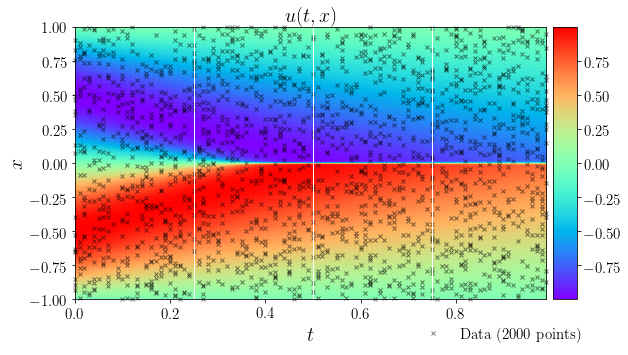

In [120]:

""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

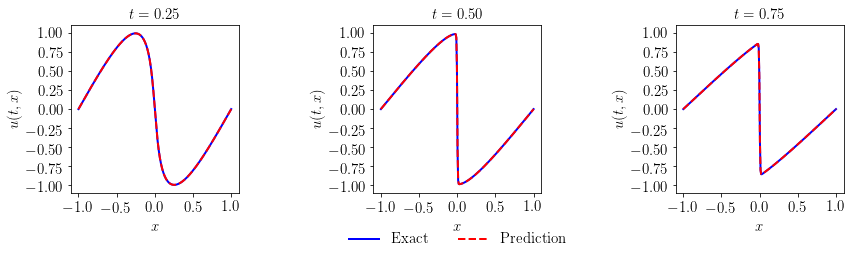

In [116]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

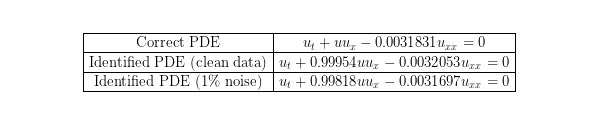

In [139]:
####### Row 3: Identified PDE ##################    

fig = plt.figure(figsize=(8, 5))

gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct PDE & $u_t + u u_x - 0.0031831 u_{xx} = 0$ \\  \hline Identified PDE (clean data) & '
s2 = r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$ \\  \hline ' % (lambda_1_value, lambda_2_value)
s3 = r'Identified PDE (1\% noise) & '
s4 = r'$u_t + %.5f u u_x - %.7f u_{xx} = 0$  \\  \hline ' % (lambda_1_value_noisy, lambda_2_value_noisy)
s5 = r'\end{tabular}$'
s = s1+s2+s3+s4+s5
ax.text(0.1, 0.1,s)

plt.show()